# 🏪 Комплексный анализ розничной сети магазинов

**Цель:** Исследование жизненного цикла магазинов, расчёт экономических и финансовых показателей

**Данные:** 20 магазинов, 10 товарных категорий, 2019-2026 (84 месяца)

---

In [8]:
# ============================================================
# НАСТРОЙКА ОКРУЖЕНИЯ
# ============================================================
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

print("✓ Библиотеки загружены")

✓ Библиотеки загружены


In [9]:
# ============================================================
# ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
# ============================================================
df = pd.read_excel('final_flat_clean.xlsx')

# Словарь месяцев
month_map = {
    "Январь": 1, "Февраль": 2, "Март": 3, "Апрель": 4, "Май": 5, "Июнь": 6,
    "Июль": 7, "Август": 8, "Сентябрь": 9, "Октябрь": 10, "Ноябрь": 11, "Декабрь": 12
}

# Создаём дату
df['Month_Num'] = df['Месяц'].map(month_map)
df['Дата'] = pd.to_datetime(dict(year=df['Год'], month=df['Month_Num'], day=1))

# Сортировка магазинов по номеру
df['Store_ID'] = df['Магазин'].str.extract(r'(\d+)').astype(int)
df = df.sort_values(['Store_ID', 'Дата', 'Товар']).reset_index(drop=True)

# ============================================================
# РАСЧЁТ БАЗОВЫХ МЕТРИК
# ============================================================
# Выручка = Число чеков × Сумма в чеке
df['Выручка'] = df['Число чеков'] * df['Сумма в чеке']

# Валовая прибыль = Число чеков × Наценка
df['Валовая_прибыль'] = df['Число чеков'] * df['Наценка продажи в чеке']

# Маржинальность %
df['Маржа_%'] = (df['Наценка продажи в чеке'] / df['Сумма в чеке'] * 100).round(2)

print(f"✓ Данные загружены: {len(df):,} строк")
print(f"  Магазинов: {df['Магазин'].nunique()}")
print(f"  Категорий: {df['Товар'].nunique()}")
print(f"  Период: {df['Дата'].min().strftime('%Y-%m')} — {df['Дата'].max().strftime('%Y-%m')}")
df.head(3)

✓ Данные загружены: 16,800 строк
  Магазинов: 20
  Категорий: 10
  Период: 2019-01 — 2025-12


,Год,Месяц,Товар,Тип,Магазин,Число чеков,Количество в чеке,Сумма в чеке,Наценка продажи в чеке,Month_Num,Дата,Store_ID,Выручка,Валовая_прибыль,Маржа_%
0,2019,Январь,Заморозка,Непрод,Магазин 1,109,5.30,"2,939.83","1,374.56",1,2019-01-01,1,"320,441.47","149,827.04",46.76
1,2019,Январь,Колбасы,Скоропорт,Магазин 1,167,9.26,723.91,166.65,1,2019-01-01,1,"120,892.97","27,830.55",23.02
2,2019,Январь,Крупы,Товар,Магазин 1,508,1.63,"2,592.91","1,057.61",1,2019-01-01,1,"1,317,198.28","537,265.88",40.79


---
# 📊 БЛОК 1: ЖИЗНЕННЫЙ ЦИКЛ МАГАЗИНА

Анализ фаз развития: **Запуск → Рост → Зрелость → Насыщение → Спад**

---

In [7]:
# ============================================================
# 1.1 АГРЕГАЦИЯ ПО МАГАЗИНАМ И МЕСЯЦАМ
# ============================================================
# Схлопываем товары — получаем общую выручку магазина за месяц
df_store = df.groupby(['Магазин', 'Store_ID', 'Дата']).agg({
    'Выручка': 'sum',
    'Валовая_прибыль': 'sum',
    'Число чеков': 'sum',
    'Количество в чеке': 'mean',
    'Сумма в чеке': 'mean',
    'Маржа_%': 'mean'
}).reset_index()

df_store = df_store.sort_values(['Store_ID', 'Дата'])

# Средний чек (пересчёт на агрегированном уровне)
df_store['Средний_чек'] = df_store['Выручка'] / df_store['Число чеков']

print(f"✓ Агрегировано: {len(df_store)} записей (магазин × месяц)")
df_store.head()

✓ Агрегировано: 1680 записей (магазин × месяц)


,Магазин,Store_ID,Дата,Выручка,Валовая_прибыль,Число чеков,Количество в чеке,Сумма в чеке,Маржа_%,Средний_чек
0,Магазин 1,1,2019-01-01,"6,305,165.67","2,244,466.73",3282,4.92,"2,008.46",34.03,"1,921.14"
1,Магазин 1,1,2019-02-01,"5,072,842.47","1,708,577.93",4905,6.92,"1,157.21",34.27,"1,034.22"
2,Магазин 1,1,2019-03-01,"4,173,605.95","1,234,902.87",3206,5.69,"1,461.39",30.84,"1,301.81"
3,Магазин 1,1,2019-04-01,"4,930,400.56","2,039,270.54",4145,4.98,"1,241.15",38.57,"1,189.48"
4,Магазин 1,1,2019-05-01,"6,027,029.12","1,941,301.04",3400,5.79,"1,597.53",34.69,"1,772.66"


In [10]:
# ============================================================
# 1.2 РАСЧЁТ ТРЕНДОВ И ПОКАЗАТЕЛЕЙ ЖИЗНЕННОГО ЦИКЛА
# ============================================================

def calculate_lifecycle_metrics(group):
    """Расчёт метрик жизненного цикла для одного магазина"""
    group = group.sort_values('Дата').copy()
    
    # 1. Скользящее среднее (тренд) — 6 месяцев
    group['Тренд_6м'] = group['Выручка'].rolling(window=6, min_periods=1).mean()
    
    # 2. Скользящее среднее — 12 месяцев (годовой тренд)
    group['Тренд_12м'] = group['Выручка'].rolling(window=12, min_periods=1).mean()
    
    # 3. Темп роста месяц к месяцу (MoM)
    group['MoM_%'] = group['Выручка'].pct_change() * 100
    
    # 4. Темп роста год к году (YoY)
    group['YoY_%'] = group['Выручка'].pct_change(periods=12) * 100
    
    # 5. Ускорение (вторая производная) — для определения точек перегиба
    group['Ускорение'] = group['Тренд_6м'].diff().diff()
    
    # 6. Нормализованный индекс (% от пика)
    max_revenue = group['Тренд_6м'].max()
    group['Индекс_от_пика'] = (group['Тренд_6м'] / max_revenue * 100).round(1)
    
    # 7. Волатильность (скользящее стандартное отклонение)
    group['Волатильность'] = group['Выручка'].rolling(window=6, min_periods=3).std()
    
    return group

# Применяем ко всем магазинам
df_lifecycle = df_store.groupby('Магазин', group_keys=False).apply(calculate_lifecycle_metrics)

print("✓ Метрики жизненного цикла рассчитаны")
df_lifecycle[['Магазин', 'Дата', 'Выручка', 'Тренд_6м', 'YoY_%', 'Индекс_от_пика']].head(15)

✓ Метрики жизненного цикла рассчитаны


,Магазин,Дата,Выручка,Тренд_6м,YoY_%,Индекс_от_пика
0,Магазин 1,2019-01-01,"6,305,165.67","6,305,165.67",NaN,72.30
1,Магазин 1,2019-02-01,"5,072,842.47","5,689,004.07",NaN,65.30
2,Магазин 1,2019-03-01,"4,173,605.95","5,183,871.36",NaN,59.50
3,Магазин 1,2019-04-01,"4,930,400.56","5,120,503.66",NaN,58.80
4,Магазин 1,2019-05-01,"6,027,029.12","5,301,808.75",NaN,60.80
5,Магазин 1,2019-06-01,"8,307,325.56","5,802,728.22",NaN,66.60
6,Магазин 1,2019-07-01,"6,727,408.22","5,873,101.98",NaN,67.40
7,Магазин 1,2019-08-01,"7,153,334.10","6,219,850.58",NaN,71.40
8,Магазин 1,2019-09-01,"6,445,922.28","6,598,569.97",NaN,75.70
9,Магазин 1,2019-10-01,"7,755,365.64","7,069,397.49",NaN,81.10


In [11]:
# ============================================================
# 1.3 ОПРЕДЕЛЕНИЕ ФАЗЫ ЖИЗНЕННОГО ЦИКЛА
# ============================================================

def determine_phase(row):
    """
    Определение фазы жизненного цикла на основе:
    - YoY% (темп роста год к году)
    - Индекс от пика (насколько далеко от максимума)
    - Ускорение (замедляется или ускоряется рост)
    """
    yoy = row['YoY_%']
    idx = row['Индекс_от_пика']
    accel = row['Ускорение']
    
    # Обработка NaN
    if pd.isna(yoy):
        return 'Запуск'  # Первый год — нет данных для сравнения
    
    # Логика определения фазы
    if yoy > 15:  # Быстрый рост
        return 'Рост'
    elif yoy > 5:  # Умеренный рост
        if idx > 90:
            return 'Зрелость'
        else:
            return 'Рост'
    elif yoy > -5:  # Стабильность (±5%)
        if idx > 85:
            return 'Зрелость'
        else:
            return 'Насыщение'
    elif yoy > -15:  # Умеренное падение
        return 'Насыщение'
    else:  # Сильное падение
        return 'Спад'

df_lifecycle['Фаза'] = df_lifecycle.apply(determine_phase, axis=1)

# Статистика по фазам
phase_stats = df_lifecycle.groupby('Фаза').agg({
    'Выручка': ['mean', 'std'],
    'YoY_%': 'mean',
    'Магазин': 'count'
}).round(0)

print("📊 Распределение по фазам жизненного цикла:")
print(df_lifecycle['Фаза'].value_counts())
print("\n")
phase_stats

📊 Распределение по фазам жизненного цикла:
Фаза
Рост         606
Спад         453
Насыщение    286
Запуск       240
Зрелость      95
Name: count, dtype: int64




Выручка               YoY_% Магазин
                  mean          std   mean   count
Фаза                                              
Запуск    7,080,750.00 1,639,174.00    NaN     240
Зрелость  7,336,315.00 1,114,040.00   3.00      95
Насыщение 6,839,147.00 1,060,451.00  -6.00     286
Рост      7,957,899.00 1,411,480.00  39.00     606
Спад      5,539,977.00 1,104,717.00 -32.00     453

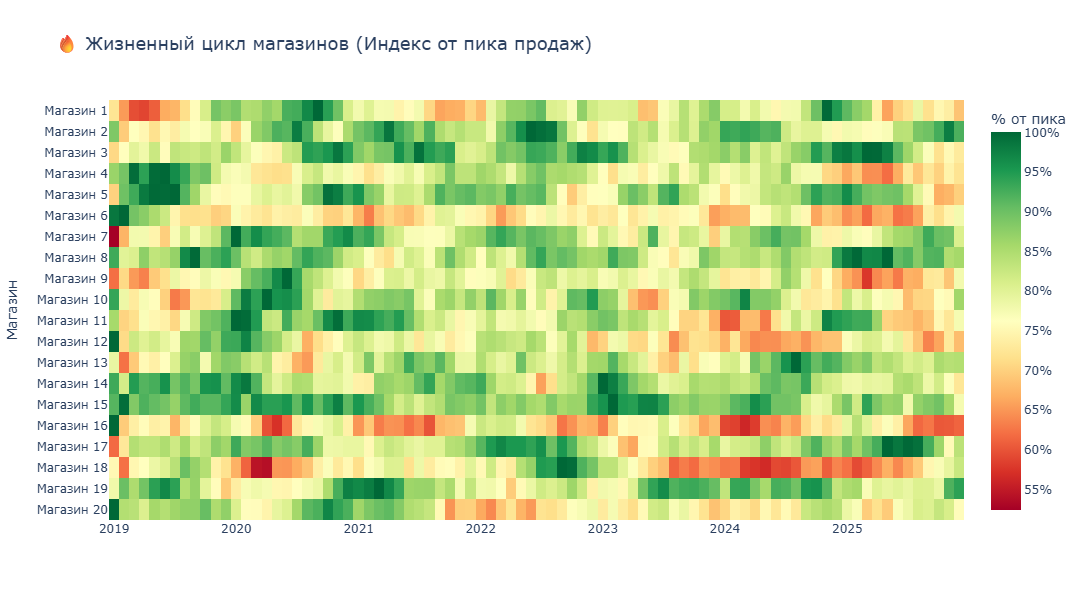

In [12]:
# ============================================================
# 1.4 ВИЗУАЛИЗАЦИЯ: HEATMAP ЖИЗНЕННОГО ЦИКЛА
# ============================================================

# Создаём pivot для heatmap
pivot_lifecycle = df_lifecycle.pivot(index='Магазин', columns='Дата', values='Индекс_от_пика')

# Сортируем магазины по номеру
store_order = [f'Магазин {i}' for i in range(1, 21)]
pivot_lifecycle = pivot_lifecycle.reindex(store_order)

fig = px.imshow(
    pivot_lifecycle,
    labels=dict(x="Период", y="Магазин", color="% от пика"),
    aspect="auto",
    color_continuous_scale="RdYlGn",  # Красный-Жёлтый-Зелёный
    title="🔥 Жизненный цикл магазинов (Индекс от пика продаж)"
)

fig.update_layout(
    height=600,
    title_font_size=18,
    xaxis_title=None,
    coloraxis_colorbar=dict(title="% от пика", ticksuffix="%")
)

fig.update_traces(
    hovertemplate="<b>%{y}</b><br>Дата: %{x|%b %Y}<br>Индекс: %{z:.1f}%<extra></extra>"
)

fig.show()

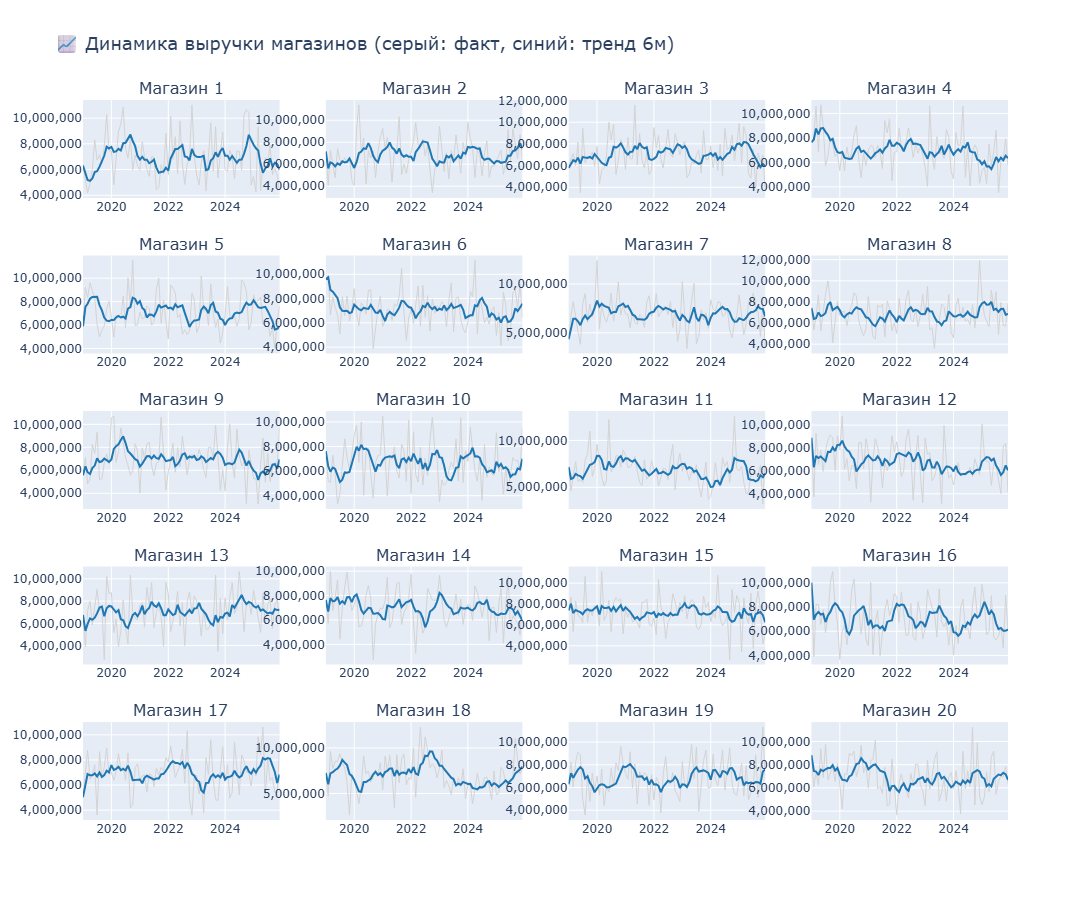

In [16]:
# ============================================================
# 1.5 ВИЗУАЛИЗАЦИЯ: ТРЕНДЫ ВЫРУЧКИ ПО МАГАЗИНАМ
# ============================================================

# Цветовая схема для фаз
phase_colors = {
    'Запуск': '#9467bd',     # Фиолетовый
    'Рост': '#2ca02c',       # Зелёный
    'Зрелость': '#1f77b4',   # Синий
    'Насыщение': '#ff7f0e',  # Оранжевый
    'Спад': '#d62728'        # Красный
}

fig = make_subplots(
    rows=5, cols=4,
    subplot_titles=[f'Магазин {i}' for i in range(1, 21)],
    vertical_spacing=0.08,
    horizontal_spacing=0.05
)

for i in range(1, 21):
    store_data = df_lifecycle[df_lifecycle['Store_ID'] == i].sort_values('Дата')
    row = (i - 1) // 4 + 1
    col = (i - 1) % 4 + 1
    
    # Линия выручки
    fig.add_trace(
        go.Scatter(
            x=store_data['Дата'],
            y=store_data['Выручка'],
            mode='lines',
            line=dict(color='lightgray', width=1),
            name='Факт',
            showlegend=False
        ),
        row=row, col=col
    )
    
    # Линия тренда
    fig.add_trace(
        go.Scatter(
            x=store_data['Дата'],
            y=store_data['Тренд_6м'],
            mode='lines',
            line=dict(color='#1f77b4', width=2),
            name='Тренд',
            showlegend=False
        ),
        row=row, col=col
    )

fig.update_layout(
    height=900,
    title_text="📈 Динамика выручки магазинов (серый: факт, синий: тренд 6м)",
    title_font_size=18,
    showlegend=False
)

fig.update_xaxes(tickformat="%Y", dtick="M24")
fig.update_yaxes(tickformat=",.0f")

fig.show()

In [14]:
# ============================================================
# 1.6 КЛАСТЕРИЗАЦИЯ МАГАЗИНОВ ПО ТРАЕКТОРИИ
# ============================================================
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Создаём профиль каждого магазина
store_profiles = df_lifecycle.groupby('Магазин').agg({
    'Выручка': ['mean', 'std', 'min', 'max'],
    'YoY_%': 'mean',
    'Индекс_от_пика': ['mean', 'last'],
    'Волатильность': 'mean'
}).round(2)

store_profiles.columns = ['_'.join(col).strip() for col in store_profiles.columns]
store_profiles = store_profiles.reset_index()

# Признаки для кластеризации
features = ['Выручка_mean', 'Выручка_std', 'YoY_%_mean', 'Индекс_от_пика_last', 'Волатильность_mean']
X = store_profiles[features].fillna(0)

# Обработка бесконечных значений
X = X.replace([np.inf, -np.inf], np.nan)  # Заменяем бесконечности на NaN
X = X.fillna(0)  # Заменяем NaN на 0

# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means кластеризация
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
store_profiles['Кластер'] = kmeans.fit_predict(X_scaled)

# Интерпретация кластеров
cluster_names = {
    0: 'Стабильные лидеры',
    1: 'Растущие звёзды',
    2: 'Проблемные',
    3: 'Середняки'
}

# Определяем названия на основе средних значений
cluster_stats = store_profiles.groupby('Кластер')[features].mean()
print("📊 Характеристики кластеров:")
display(cluster_stats.round(0))

print("\n🏪 Распределение магазинов по кластерам:")
print(store_profiles[['Магазин', 'Кластер', 'Выручка_mean', 'YoY_%_mean', 'Индекс_от_пика_last']].sort_values('Кластер'))

📊 Характеристики кластеров:


,Выручка_mean,Выручка_std,YoY_%_mean,Индекс_от_пика_last,Волатильность_mean
Кластер,,,,,
0,"6,922,155.00","1,704,698.00",5.00,69.00,"1,611,493.00"
1,"6,890,917.00","1,572,721.00",6.00,86.00,"1,479,435.00"
2,"6,923,125.00","1,758,433.00",8.00,84.00,"1,651,259.00"
3,"7,042,395.00","1,541,243.00",3.00,74.00,"1,483,991.00"



🏪 Распределение магазинов по кластерам:
       Магазин  Кластер  Выручка_mean  YoY_%_mean  Индекс_от_пика_last
0    Магазин 1        0  6,912,304.29        3.85                68.80
3   Магазин 12        0  6,794,828.78        4.81                68.10
7   Магазин 16        0  7,052,236.51        4.90                61.20
19   Магазин 9        0  6,929,250.95        5.49                77.70
10  Магазин 19        1  6,869,512.23        7.63                94.10
11   Магазин 2        1  6,841,578.22        8.54                92.10
8   Магазин 17        1  6,962,509.97        6.57                83.70
2   Магазин 11        1  6,836,851.17        3.57                77.40
17   Магазин 7        1  6,949,371.33        6.41                80.70
18   Магазин 8        1  6,885,678.60        4.85                85.70
4   Магазин 13        2  7,057,784.44        8.55                84.50
1   Магазин 10        2  6,664,630.96        8.61                86.00
9   Магазин 18        2  7,046,958.2

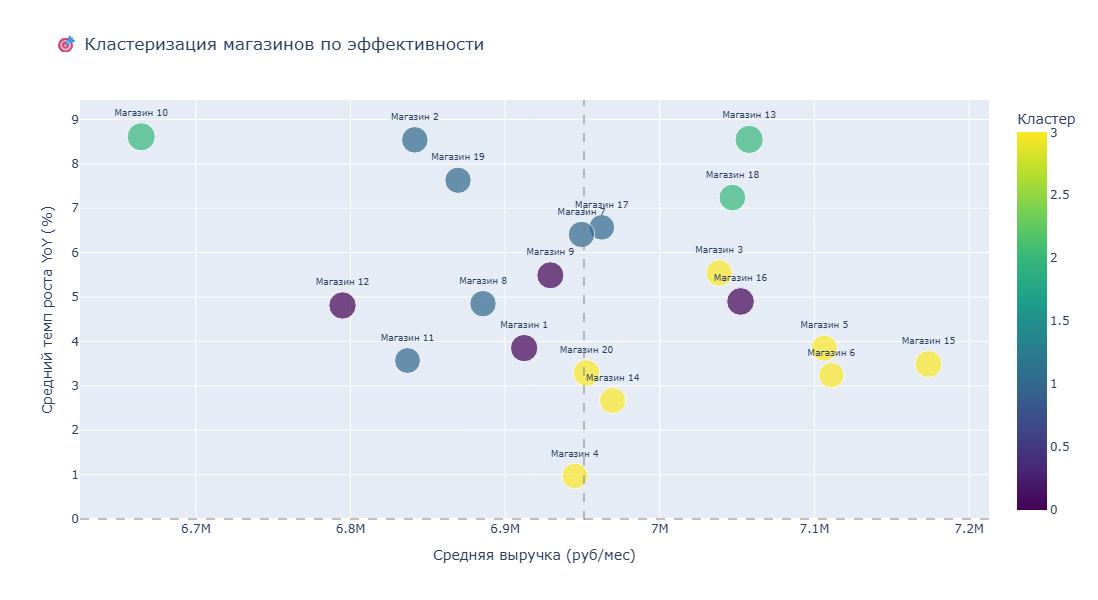

In [15]:
# ============================================================
# 1.7 ВИЗУАЛИЗАЦИЯ КЛАСТЕРОВ
# ============================================================

fig = px.scatter(
    store_profiles,
    x='Выручка_mean',
    y='YoY_%_mean',
    size='Волатильность_mean',
    color='Кластер',
    text='Магазин',
    title='🎯 Кластеризация магазинов по эффективности',
    labels={
        'Выручка_mean': 'Средняя выручка (руб/мес)',
        'YoY_%_mean': 'Средний темп роста YoY (%)',
        'Волатильность_mean': 'Волатильность'
    },
    color_continuous_scale='Viridis'
)

fig.update_traces(textposition='top center', textfont_size=9)
fig.update_layout(height=600)

# Добавляем линии осей
fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=store_profiles['Выручка_mean'].median(), line_dash="dash", line_color="gray", opacity=0.5)

fig.show()

In [17]:
# ============================================================
# 1.8 СВОДНАЯ ТАБЛИЦА ЖИЗНЕННОГО ЦИКЛА
# ============================================================

# Текущая фаза для каждого магазина (последний месяц)
current_phase = df_lifecycle.sort_values('Дата').groupby('Магазин').last()[['Фаза', 'Индекс_от_пика', 'YoY_%']]

# Объединяем с профилями
lifecycle_summary = store_profiles.merge(current_phase, on='Магазин')

# Расчёт CAGR (среднегодовой темп роста)
def calc_cagr(store_name):
    data = df_lifecycle[df_lifecycle['Магазин'] == store_name].sort_values('Дата')
    first_year = data.groupby(data['Дата'].dt.year)['Выручка'].sum().iloc[0]
    last_year = data.groupby(data['Дата'].dt.year)['Выручка'].sum().iloc[-1]
    years = data['Дата'].dt.year.nunique() - 1
    if years > 0 and first_year > 0:
        return ((last_year / first_year) ** (1/years) - 1) * 100
    return 0

lifecycle_summary['CAGR_%'] = lifecycle_summary['Магазин'].apply(calc_cagr).round(1)

# Финальная сводка
final_summary = lifecycle_summary[[
    'Магазин', 'Кластер', 'Фаза', 'Выручка_mean', 'YoY_%', 'CAGR_%', 'Индекс_от_пика', 'Волатильность_mean'
]].sort_values('Выручка_mean', ascending=False)

final_summary.columns = ['Магазин', 'Кластер', 'Текущая фаза', 'Ср. выручка', 'YoY%', 'CAGR%', 'Индекс от пика', 'Волатильность']

print("📋 СВОДНАЯ ТАБЛИЦА ЖИЗНЕННОГО ЦИКЛА МАГАЗИНОВ")
print("="*80)
final_summary

📋 СВОДНАЯ ТАБЛИЦА ЖИЗНЕННОГО ЦИКЛА МАГАЗИНОВ


,Магазин,Кластер,Текущая фаза,Ср. выручка,YoY%,CAGR%,Индекс от пика,Волатильность
6,Магазин 15,3,Спад,"7,173,773.92",-42.81,-1.80,77.50,"1,558,646.38"
16,Магазин 6,3,Насыщение,"7,111,035.36",-12.24,-1.40,77.70,"1,396,886.35"
15,Магазин 5,3,Рост,"7,106,383.15",22.76,-1.50,69.90,"1,487,978.40"
4,Магазин 13,2,Насыщение,"7,057,784.44",-9.47,0.30,84.50,"1,715,756.98"
7,Магазин 16,0,Спад,"7,052,236.51",-16.41,-2.30,61.20,"1,651,244.27"
9,Магазин 18,2,Насыщение,"7,046,958.22",3.55,-0.60,82.50,"1,535,152.45"
13,Магазин 3,3,Спад,"7,038,386.11",-52.79,0.20,73.10,"1,504,182.21"
5,Магазин 14,3,Рост,"6,969,529.35",6.93,-2.80,72.50,"1,479,824.21"
8,Магазин 17,1,Рост,"6,962,509.97",55.98,1.10,83.70,"1,415,645.91"
12,Магазин 20,3,Рост,"6,952,576.06",20.64,-1.90,75.80,"1,531,126.97"


---
# 📈 БЛОК 2: ОПЕРАЦИОННАЯ ЭФФЕКТИВНОСТЬ

Ключевые KPI магазина: выручка, трафик, средний чек, маржа, UPT

---

In [18]:
# ============================================================
# 2.1 РАСЧЁТ ВСЕХ KPI НА УРОВНЕ МАГАЗИНА
# ============================================================

# Агрегация по магазинам (за весь период)
kpi_store = df.groupby('Магазин').agg({
    'Выручка': 'sum',
    'Валовая_прибыль': 'sum',
    'Число чеков': 'sum',
    'Количество в чеке': 'mean',
    'Сумма в чеке': 'mean',
    'Наценка продажи в чеке': 'mean',
    'Маржа_%': 'mean',
    'Store_ID': 'first'
}).reset_index()

# Расчёт производных KPI
kpi_store['Средний_чек'] = kpi_store['Выручка'] / kpi_store['Число чеков']
kpi_store['UPT'] = kpi_store['Количество в чеке']  # Units per Transaction
kpi_store['Gross_Margin_%'] = (kpi_store['Валовая_прибыль'] / kpi_store['Выручка'] * 100).round(2)
kpi_store['Прибыль_на_чек'] = kpi_store['Валовая_прибыль'] / kpi_store['Число чеков']

# Индексы относительно среднего по сети
kpi_store['Индекс_выручки'] = (kpi_store['Выручка'] / kpi_store['Выручка'].mean() * 100).round(1)
kpi_store['Индекс_трафика'] = (kpi_store['Число чеков'] / kpi_store['Число чеков'].mean() * 100).round(1)
kpi_store['Индекс_чека'] = (kpi_store['Средний_чек'] / kpi_store['Средний_чек'].mean() * 100).round(1)
kpi_store['Индекс_маржи'] = (kpi_store['Gross_Margin_%'] / kpi_store['Gross_Margin_%'].mean() * 100).round(1)

kpi_store = kpi_store.sort_values('Store_ID')

print("📊 KPI МАГАЗИНОВ (за весь период)")
print("="*100)
kpi_store[['Магазин', 'Выручка', 'Валовая_прибыль', 'Число чеков', 'Средний_чек', 'UPT', 'Gross_Margin_%']].round(0)

📊 KPI МАГАЗИНОВ (за весь период)


,Магазин,Выручка,Валовая_прибыль,Число чеков,Средний_чек,UPT,Gross_Margin_%
0,Магазин 1,"580,633,560.00","200,894,042.00",354146,"1,640.00",5.00,35.00
11,Магазин 2,"574,692,570.00","199,496,382.00",355168,"1,618.00",5.00,35.00
13,Магазин 3,"591,224,433.00","204,228,745.00",361043,"1,638.00",5.00,35.00
14,Магазин 4,"583,386,978.00","204,515,671.00",355721,"1,640.00",5.00,35.00
15,Магазин 5,"596,936,184.00","208,306,559.00",361282,"1,652.00",6.00,35.00
16,Магазин 6,"597,326,970.00","206,441,161.00",366060,"1,632.00",5.00,35.00
17,Магазин 7,"583,747,192.00","202,162,089.00",356914,"1,636.00",5.00,35.00
18,Магазин 8,"578,397,003.00","204,887,324.00",358140,"1,615.00",6.00,35.00
19,Магазин 9,"582,057,079.00","202,387,943.00",352664,"1,650.00",6.00,35.00
1,Магазин 10,"559,829,000.00","197,656,637.00",355818,"1,573.00",5.00,35.00


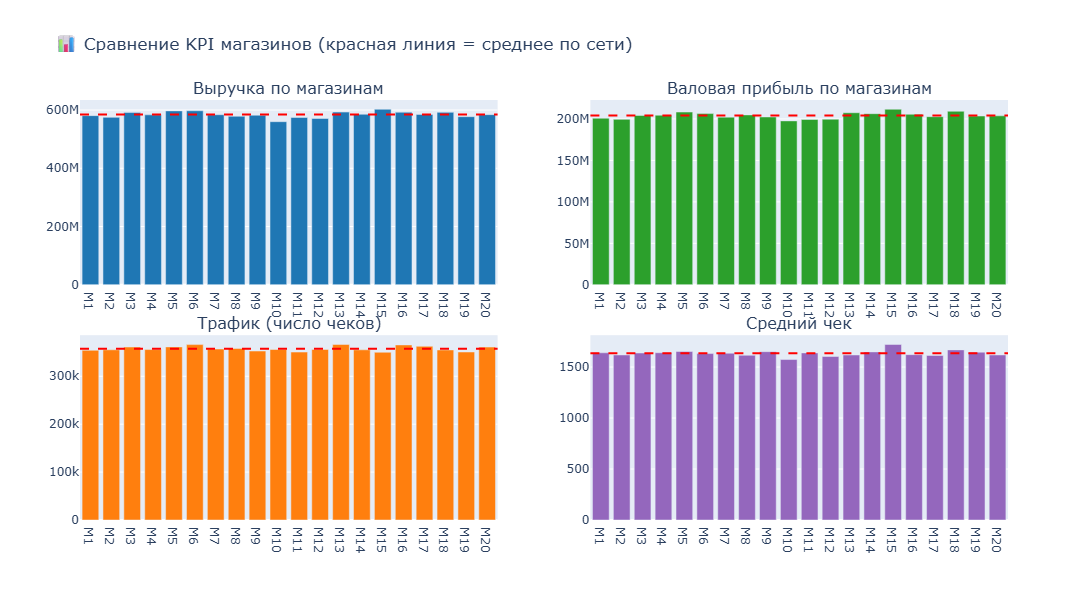

In [19]:
# ============================================================
# 2.2 ВИЗУАЛИЗАЦИЯ: СРАВНИТЕЛЬНАЯ ДИАГРАММА KPI
# ============================================================

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Выручка по магазинам', 
        'Валовая прибыль по магазинам',
        'Трафик (число чеков)',
        'Средний чек'
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

store_names = [f'М{i}' for i in range(1, 21)]

# 1. Выручка
fig.add_trace(
    go.Bar(x=store_names, y=kpi_store['Выручка'], marker_color='#1f77b4', name='Выручка'),
    row=1, col=1
)
fig.add_hline(y=kpi_store['Выручка'].mean(), line_dash="dash", line_color="red", row=1, col=1)

# 2. Валовая прибыль
fig.add_trace(
    go.Bar(x=store_names, y=kpi_store['Валовая_прибыль'], marker_color='#2ca02c', name='Прибыль'),
    row=1, col=2
)
fig.add_hline(y=kpi_store['Валовая_прибыль'].mean(), line_dash="dash", line_color="red", row=1, col=2)

# 3. Трафик
fig.add_trace(
    go.Bar(x=store_names, y=kpi_store['Число чеков'], marker_color='#ff7f0e', name='Чеки'),
    row=2, col=1
)
fig.add_hline(y=kpi_store['Число чеков'].mean(), line_dash="dash", line_color="red", row=2, col=1)

# 4. Средний чек
fig.add_trace(
    go.Bar(x=store_names, y=kpi_store['Средний_чек'], marker_color='#9467bd', name='Ср.чек'),
    row=2, col=2
)
fig.add_hline(y=kpi_store['Средний_чек'].mean(), line_dash="dash", line_color="red", row=2, col=2)

fig.update_layout(
    height=600,
    title_text="📊 Сравнение KPI магазинов (красная линия = среднее по сети)",
    showlegend=False
)

fig.show()

In [20]:
# ============================================================
# 2.3 ДИНАМИКА KPI ВО ВРЕМЕНИ
# ============================================================

# Агрегация по месяцам (вся сеть)
kpi_monthly = df.groupby('Дата').agg({
    'Выручка': 'sum',
    'Валовая_прибыль': 'sum',
    'Число чеков': 'sum',
    'Маржа_%': 'mean'
}).reset_index()

kpi_monthly['Средний_чек'] = kpi_monthly['Выручка'] / kpi_monthly['Число чеков']
kpi_monthly['Gross_Margin_%'] = kpi_monthly['Валовая_прибыль'] / kpi_monthly['Выручка'] * 100

# Скользящие средние для трендов
kpi_monthly['Выручка_тренд'] = kpi_monthly['Выручка'].rolling(6, min_periods=1).mean()
kpi_monthly['Чек_тренд'] = kpi_monthly['Средний_чек'].rolling(6, min_periods=1).mean()
kpi_monthly['Трафик_тренд'] = kpi_monthly['Число чеков'].rolling(6, min_periods=1).mean()

# Темпы роста YoY
kpi_monthly['Выручка_YoY'] = kpi_monthly['Выручка'].pct_change(12) * 100
kpi_monthly['Трафик_YoY'] = kpi_monthly['Число чеков'].pct_change(12) * 100
kpi_monthly['Чек_YoY'] = kpi_monthly['Средний_чек'].pct_change(12) * 100

print("📈 Динамика KPI сети по месяцам")
kpi_monthly[['Дата', 'Выручка', 'Число чеков', 'Средний_чек', 'Gross_Margin_%', 'Выручка_YoY']].tail(12).round(1)

📈 Динамика KPI сети по месяцам


,Дата,Выручка,Число чеков,Средний_чек,Gross_Margin_%,Выручка_YoY
72,2025-01-01,"144,406,444.70",87121,"1,657.50",35.70,16.40
73,2025-02-01,"128,717,423.20",83565,"1,540.30",35.60,-12.60
74,2025-03-01,"135,289,602.60",81680,"1,656.30",33.80,-3.30
75,2025-04-01,"127,466,487.80",80855,"1,576.50",34.40,-8.50
76,2025-05-01,"139,678,154.20",86302,"1,618.50",35.50,-2.70
77,2025-06-01,"132,476,645.20",85222,"1,554.50",36.10,-2.80
78,2025-07-01,"133,229,620.80",79280,"1,680.50",35.20,-0.20
79,2025-08-01,"131,112,841.70",83875,"1,563.20",33.50,-5.90
80,2025-09-01,"136,596,143.70",88230,"1,548.20",35.60,-5.70
81,2025-10-01,"129,408,889.80",85004,"1,522.40",34.00,-4.30


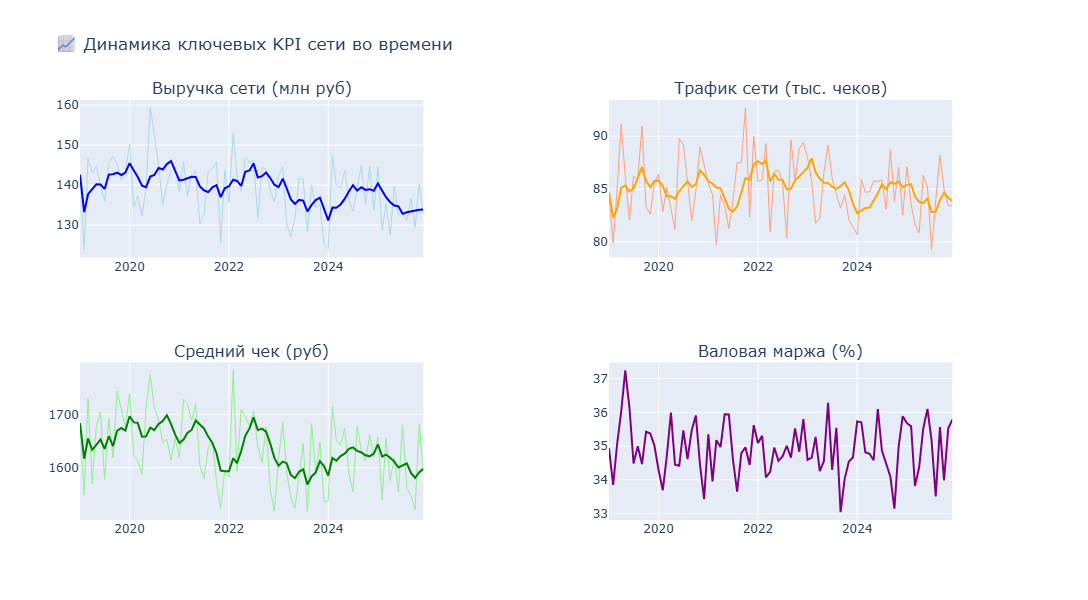

In [21]:
# ============================================================
# 2.4 ВИЗУАЛИЗАЦИЯ: ДИНАМИКА KPI СЕТИ
# ============================================================

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        'Выручка сети (млн руб)', 
        'Трафик сети (тыс. чеков)',
        'Средний чек (руб)',
        'Валовая маржа (%)'
    ],
    specs=[[{"secondary_y": True}, {"secondary_y": True}],
           [{"secondary_y": True}, {"secondary_y": True}]]
)

# 1. Выручка
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Выручка']/1e6, 
               mode='lines', line=dict(color='lightblue', width=1), name='Факт'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Выручка_тренд']/1e6, 
               mode='lines', line=dict(color='blue', width=2), name='Тренд'),
    row=1, col=1
)

# 2. Трафик
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Число чеков']/1e3, 
               mode='lines', line=dict(color='lightsalmon', width=1), name='Факт'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Трафик_тренд']/1e3, 
               mode='lines', line=dict(color='orange', width=2), name='Тренд'),
    row=1, col=2
)

# 3. Средний чек
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Средний_чек'], 
               mode='lines', line=dict(color='lightgreen', width=1), name='Факт'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Чек_тренд'], 
               mode='lines', line=dict(color='green', width=2), name='Тренд'),
    row=2, col=1
)

# 4. Маржа
fig.add_trace(
    go.Scatter(x=kpi_monthly['Дата'], y=kpi_monthly['Gross_Margin_%'], 
               mode='lines', line=dict(color='purple', width=2), name='Маржа'),
    row=2, col=2
)

fig.update_layout(
    height=600,
    title_text="📈 Динамика ключевых KPI сети во времени",
    showlegend=False
)

fig.show()

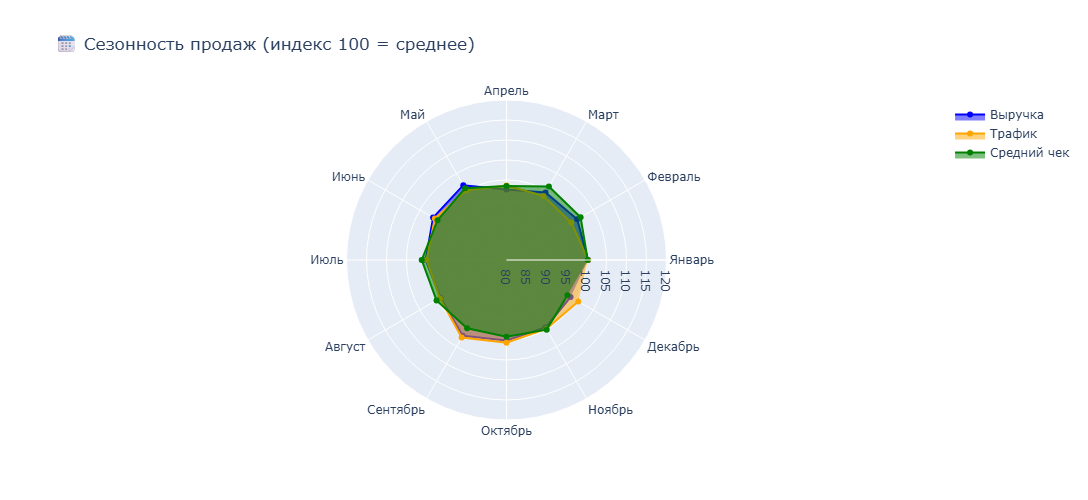


📊 Сезонные индексы:


,Месяц,Индекс_выручки,Индекс_трафика,Индекс_чека
11,Январь,100.40,100.40,100.30
10,Февраль,100.40,98.70,101.40
6,Март,99.50,98.50,101.20
1,Апрель,97.60,98.60,98.50
5,Май,101.60,100.10,100.70
4,Июнь,101.20,100.70,99.90
3,Июль,100.20,100.00,101.20
0,Август,99.00,99.20,100.20
9,Сентябрь,101.90,102.40,99.70
8,Октябрь,100.10,100.70,99.20


In [22]:
# ============================================================
# 2.5 СЕЗОННОСТЬ: ИНДЕКСЫ ПО МЕСЯЦАМ
# ============================================================

# Расчёт сезонных индексов
seasonality = df.groupby('Месяц').agg({
    'Выручка': 'mean',
    'Число чеков': 'mean',
    'Сумма в чеке': 'mean'
}).reset_index()

# Нормируем относительно среднего
seasonality['Индекс_выручки'] = (seasonality['Выручка'] / seasonality['Выручка'].mean() * 100).round(1)
seasonality['Индекс_трафика'] = (seasonality['Число чеков'] / seasonality['Число чеков'].mean() * 100).round(1)
seasonality['Индекс_чека'] = (seasonality['Сумма в чеке'] / seasonality['Сумма в чеке'].mean() * 100).round(1)

# Порядок месяцев
month_order = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь",
               "Июль", "Август", "Сентябрь", "Октябрь", "Ноябрь", "Декабрь"]
seasonality['Месяц'] = pd.Categorical(seasonality['Месяц'], categories=month_order, ordered=True)
seasonality = seasonality.sort_values('Месяц')

# Визуализация
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=seasonality['Индекс_выручки'],
    theta=seasonality['Месяц'],
    fill='toself',
    name='Выручка',
    line_color='blue'
))

fig.add_trace(go.Scatterpolar(
    r=seasonality['Индекс_трафика'],
    theta=seasonality['Месяц'],
    fill='toself',
    name='Трафик',
    line_color='orange'
))

fig.add_trace(go.Scatterpolar(
    r=seasonality['Индекс_чека'],
    theta=seasonality['Месяц'],
    fill='toself',
    name='Средний чек',
    line_color='green'
))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[80, 120])),
    title="🗓️ Сезонность продаж (индекс 100 = среднее)",
    height=500
)

fig.show()

print("\n📊 Сезонные индексы:")
seasonality[['Месяц', 'Индекс_выручки', 'Индекс_трафика', 'Индекс_чека']]

In [23]:
# ============================================================
# 2.6 СВОДНАЯ ТАБЛИЦА ЭФФЕКТИВНОСТИ МАГАЗИНОВ
# ============================================================

# Рейтинг магазинов по комплексному показателю
kpi_store['Рейтинг_выручки'] = kpi_store['Выручка'].rank(ascending=False).astype(int)
kpi_store['Рейтинг_маржи'] = kpi_store['Gross_Margin_%'].rank(ascending=False).astype(int)
kpi_store['Рейтинг_трафика'] = kpi_store['Число чеков'].rank(ascending=False).astype(int)
kpi_store['Рейтинг_чека'] = kpi_store['Средний_чек'].rank(ascending=False).astype(int)

# Комплексный рейтинг (среднее место)
kpi_store['Комплексный_рейтинг'] = (
    kpi_store['Рейтинг_выручки'] + 
    kpi_store['Рейтинг_маржи'] + 
    kpi_store['Рейтинг_трафика'] + 
    kpi_store['Рейтинг_чека']
) / 4

# Определение статуса
def get_status(rank):
    if rank <= 5:
        return '🟢 Лидер'
    elif rank <= 10:
        return '🟡 Выше среднего'
    elif rank <= 15:
        return '🟠 Ниже среднего'
    else:
        return '🔴 Аутсайдер'

kpi_store['Статус'] = kpi_store['Комплексный_рейтинг'].apply(get_status)

# Финальная таблица
efficiency_table = kpi_store[[
    'Магазин', 'Статус', 'Комплексный_рейтинг',
    'Выручка', 'Рейтинг_выручки',
    'Gross_Margin_%', 'Рейтинг_маржи',
    'Число чеков', 'Рейтинг_трафика',
    'Средний_чек', 'Рейтинг_чека'
]].sort_values('Комплексный_рейтинг')

print("📋 РЕЙТИНГ ЭФФЕКТИВНОСТИ МАГАЗИНОВ")
print("="*100)
efficiency_table.round(1)

📋 РЕЙТИНГ ЭФФЕКТИВНОСТИ МАГАЗИНОВ


,Магазин,Статус,Комплексный_рейтинг,Выручка,Рейтинг_выручки,Gross_Margin_%,Рейтинг_маржи,Число чеков,Рейтинг_трафика,Средний_чек,Рейтинг_чека
15,Магазин 5,🟡 Выше среднего,5.20,"596,936,184.30",3,34.90,10,361282,5,"1,652.30",3
9,Магазин 18,🟡 Выше среднего,6.20,"591,944,490.50",6,35.40,2,354877,15,"1,668.00",2
6,Магазин 15,🟡 Выше среднего,7.00,"602,597,009.10",1,35.10,6,350069,20,"1,721.40",1
4,Магазин 13,🟡 Выше среднего,7.20,"592,853,893.20",4,35.00,8,366438,1,"1,617.90",16
5,Магазин 14,🟡 Выше среднего,7.80,"585,440,465.20",8,35.20,5,355194,13,"1,648.20",5
7,Магазин 16,🟡 Выше среднего,8.50,"592,387,866.90",5,34.70,13,365422,3,"1,621.10",13
16,Магазин 6,🟡 Выше среднего,8.80,"597,326,970.10",2,34.60,19,366060,2,"1,631.80",12
14,Магазин 4,🟡 Выше среднего,9.50,"583,386,978.00",12,35.10,7,355721,12,"1,640.00",7
18,Магазин 8,🟠 Ниже среднего,10.20,"578,397,002.60",15,35.40,1,358140,8,"1,615.00",17
12,Магазин 20,🟠 Ниже среднего,10.50,"584,016,388.80",10,34.90,11,360930,7,"1,618.10",14


---
# 🔬 БЛОК 3: ПРОДВИНУТАЯ АНАЛИТИКА

- Анализ по типам товаров (Скоропорт / Товар / Непрод)
- ABC/XYZ анализ
- Декомпозиция выручки
- Когортный анализ категорий

---

In [24]:
# ============================================================
# 3.1 АНАЛИЗ ПО ТИПАМ ТОВАРОВ
# ============================================================

# Проверяем наличие колонки Тип
if 'Тип' not in df.columns:
    print("⚠️ Колонка 'Тип' не найдена. Перезапустите Untitled.ipynb для обновления данных.")
else:
    print(f"✓ Найдены типы товаров: {df['Тип'].unique()}")
    
    # Агрегация по типам
    type_analysis = df.groupby('Тип').agg({
        'Выручка': 'sum',
        'Валовая_прибыль': 'sum',
        'Число чеков': 'sum',
        'Маржа_%': 'mean'
    }).reset_index()
    
    type_analysis['Средний_чек'] = type_analysis['Выручка'] / type_analysis['Число чеков']
    type_analysis['Gross_Margin_%'] = (type_analysis['Валовая_прибыль'] / type_analysis['Выручка'] * 100).round(2)
    type_analysis['Доля_выручки_%'] = (type_analysis['Выручка'] / type_analysis['Выручка'].sum() * 100).round(1)
    type_analysis['Доля_прибыли_%'] = (type_analysis['Валовая_прибыль'] / type_analysis['Валовая_прибыль'].sum() * 100).round(1)
    
    print("\n📊 АНАЛИЗ ПО ТИПАМ ТОВАРОВ")
    print("="*80)
    display(type_analysis.round(0))

✓ Найдены типы товаров: ['Непрод' 'Скоропорт' 'Товар']

📊 АНАЛИЗ ПО ТИПАМ ТОВАРОВ


,Тип,Выручка,Валовая_прибыль,Число чеков,Маржа_%,Средний_чек,Gross_Margin_%,Доля_выручки_%,Доля_прибыли_%
0,Непрод,"1,186,359,748.00","410,685,494.00",721969,35.00,"1,643.00",35.00,10.00,10.00
1,Скоропорт,"6,983,759,440.00","2,436,776,947.00",4277768,35.00,"1,633.00",35.00,60.00,60.00
2,Товар,"3,514,302,877.00","1,233,105,497.00",2149943,35.00,"1,635.00",35.00,30.00,30.00


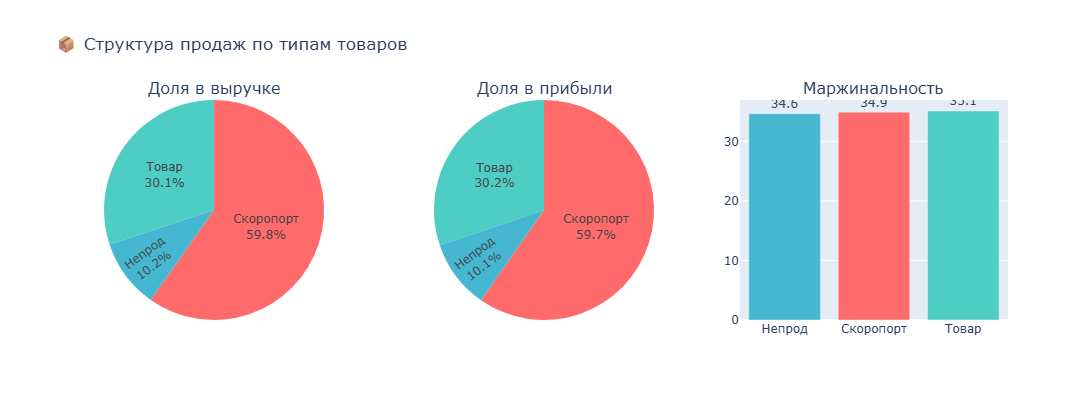

In [25]:
# ============================================================
# 3.2 ВИЗУАЛИЗАЦИЯ: СТРУКТУРА ПО ТИПАМ ТОВАРОВ
# ============================================================

if 'Тип' in df.columns:
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=['Доля в выручке', 'Доля в прибыли', 'Маржинальность'],
        specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "bar"}]]
    )
    
    colors = {'Скоропорт': '#ff6b6b', 'Товар': '#4ecdc4', 'Непрод': '#45b7d1'}
    color_list = [colors.get(t, '#808080') for t in type_analysis['Тип']]
    
    # Pie 1: Выручка
    fig.add_trace(
        go.Pie(labels=type_analysis['Тип'], values=type_analysis['Выручка'],
               marker=dict(colors=color_list), textinfo='label+percent'),
        row=1, col=1
    )
    
    # Pie 2: Прибыль
    fig.add_trace(
        go.Pie(labels=type_analysis['Тип'], values=type_analysis['Валовая_прибыль'],
               marker=dict(colors=color_list), textinfo='label+percent'),
        row=1, col=2
    )
    
    # Bar: Маржа
    fig.add_trace(
        go.Bar(x=type_analysis['Тип'], y=type_analysis['Gross_Margin_%'],
               marker=dict(color=color_list), text=type_analysis['Gross_Margin_%'].round(1),
               textposition='outside'),
        row=1, col=3
    )
    
    fig.update_layout(
        height=400,
        title_text="📦 Структура продаж по типам товаров",
        showlegend=False
    )
    
    fig.show()

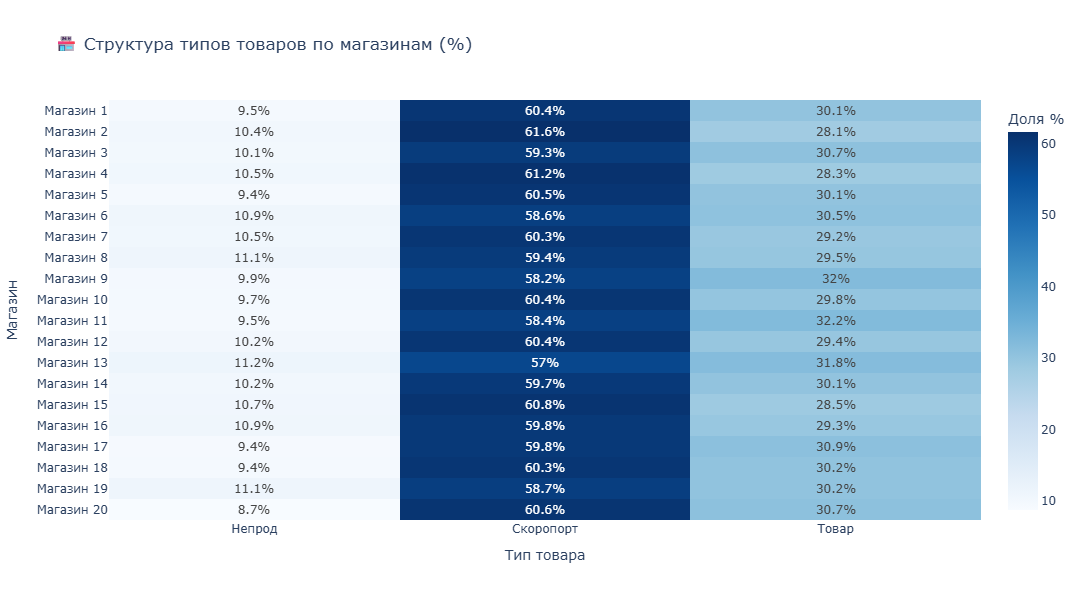


📊 Доля типов товаров по магазинам (%):


Тип,Непрод,Скоропорт,Товар
Магазин,,,
Магазин 1,9.50,60.40,30.10
Магазин 2,10.40,61.60,28.10
Магазин 3,10.10,59.30,30.70
Магазин 4,10.50,61.20,28.30
Магазин 5,9.40,60.50,30.10
Магазин 6,10.90,58.60,30.50
Магазин 7,10.50,60.30,29.20
Магазин 8,11.10,59.40,29.50
Магазин 9,9.90,58.20,32.00


In [26]:
# ============================================================
# 3.3 ТИПЫ ТОВАРОВ ПО МАГАЗИНАМ (HEATMAP)
# ============================================================

if 'Тип' in df.columns:
    # Pivot: магазин × тип → выручка
    type_by_store = df.groupby(['Магазин', 'Тип'])['Выручка'].sum().unstack(fill_value=0)
    
    # Нормализация по строкам (доля каждого типа в магазине)
    type_by_store_pct = type_by_store.div(type_by_store.sum(axis=1), axis=0) * 100
    
    # Сортировка магазинов
    store_order = [f'Магазин {i}' for i in range(1, 21)]
    type_by_store_pct = type_by_store_pct.reindex(store_order)
    
    fig = px.imshow(
        type_by_store_pct,
        labels=dict(x="Тип товара", y="Магазин", color="Доля %"),
        aspect="auto",
        color_continuous_scale="Blues",
        title="🏪 Структура типов товаров по магазинам (%)"
    )
    
    fig.update_layout(height=600)
    fig.update_traces(
        text=type_by_store_pct.round(1).values,
        texttemplate="%{text}%",
        hovertemplate="<b>%{y}</b><br>%{x}: %{z:.1f}%<extra></extra>"
    )
    
    fig.show()
    
    print("\n📊 Доля типов товаров по магазинам (%):")
    display(type_by_store_pct.round(1))

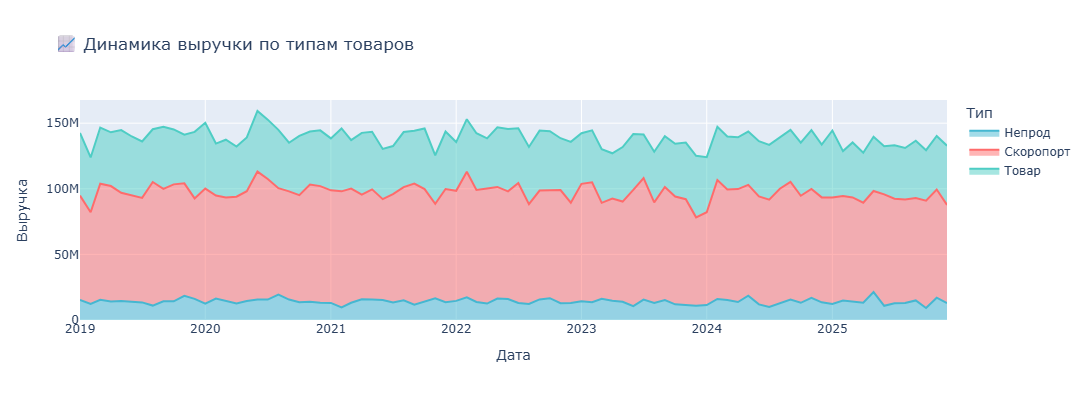

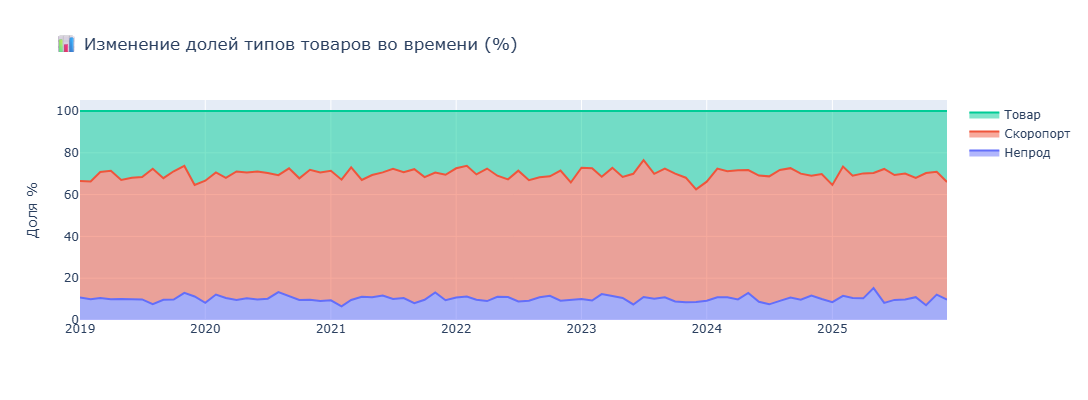

In [27]:
# ============================================================
# 3.4 ДИНАМИКА ТИПОВ ТОВАРОВ ВО ВРЕМЕНИ
# ============================================================

if 'Тип' in df.columns:
    # Агрегация по дате и типу
    type_dynamics = df.groupby(['Дата', 'Тип']).agg({
        'Выручка': 'sum',
        'Валовая_прибыль': 'sum'
    }).reset_index()
    
    # Stacked area chart
    fig = px.area(
        type_dynamics,
        x='Дата',
        y='Выручка',
        color='Тип',
        title='📈 Динамика выручки по типам товаров',
        color_discrete_map={'Скоропорт': '#ff6b6b', 'Товар': '#4ecdc4', 'Непрод': '#45b7d1'}
    )
    
    fig.update_layout(height=400)
    fig.show()
    
    # Линейный график долей
    type_pivot = type_dynamics.pivot(index='Дата', columns='Тип', values='Выручка')
    type_share = type_pivot.div(type_pivot.sum(axis=1), axis=0) * 100
    
    fig2 = go.Figure()
    for col in type_share.columns:
        fig2.add_trace(go.Scatter(
            x=type_share.index, y=type_share[col],
            mode='lines', name=col, stackgroup='one'
        ))
    
    fig2.update_layout(
        title='📊 Изменение долей типов товаров во времени (%)',
        height=400,
        yaxis_title='Доля %'
    )
    fig2.show()

In [28]:
# ============================================================
# 3.5 ABC-АНАЛИЗ ТОВАРНЫХ КАТЕГОРИЙ
# ============================================================

# ABC по выручке
abc_data = df.groupby('Товар').agg({
    'Выручка': 'sum',
    'Валовая_прибыль': 'sum',
    'Число чеков': 'sum'
}).reset_index()

abc_data = abc_data.sort_values('Выручка', ascending=False)
abc_data['Выручка_накоп'] = abc_data['Выручка'].cumsum()
abc_data['Доля_накоп_%'] = (abc_data['Выручка_накоп'] / abc_data['Выручка'].sum() * 100).round(1)
abc_data['Доля_%'] = (abc_data['Выручка'] / abc_data['Выручка'].sum() * 100).round(1)

# Присвоение ABC-класса
def assign_abc(cumsum_pct):
    if cumsum_pct <= 80:
        return 'A'
    elif cumsum_pct <= 95:
        return 'B'
    else:
        return 'C'

abc_data['ABC'] = abc_data['Доля_накоп_%'].apply(assign_abc)

# Маржинальность
abc_data['Маржа_%'] = (abc_data['Валовая_прибыль'] / abc_data['Выручка'] * 100).round(1)

print("📊 ABC-АНАЛИЗ ТОВАРНЫХ КАТЕГОРИЙ")
print("="*80)
print("A = 80% выручки | B = 15% выручки | C = 5% выручки")
print("-"*80)
display(abc_data[['Товар', 'ABC', 'Выручка', 'Доля_%', 'Доля_накоп_%', 'Маржа_%']])

📊 ABC-АНАЛИЗ ТОВАРНЫХ КАТЕГОРИЙ
A = 80% выручки | B = 15% выручки | C = 5% выручки
--------------------------------------------------------------------------------


,Товар,ABC,Выручка,Доля_%,Доля_накоп_%,Маржа_%
1,Колбасы,A,"1,222,046,608.85",10.50,10.50,34.90
7,Сыры,A,"1,199,980,894.02",10.30,20.70,34.50
0,Заморозка,A,"1,186,359,748.08",10.20,30.90,34.60
8,Фрукты,A,"1,184,076,701.67",10.10,41.00,34.60
4,Мясо,A,"1,172,866,671.59",10.00,51.10,34.80
2,Крупы,A,"1,157,643,143.12",9.90,61.00,35.20
5,Напитки,A,"1,156,678,840.03",9.90,70.90,35.60
9,Хлеб,B,"1,152,335,759.18",9.90,80.70,34.80
3,Молоко,B,"1,133,773,846.54",9.70,90.40,35.20
6,Овощи,C,"1,118,659,852.55",9.60,100.00,35.10


In [29]:
# ============================================================
# 3.6 XYZ-АНАЛИЗ (СТАБИЛЬНОСТЬ СПРОСА)
# ============================================================

# Расчёт коэффициента вариации по месяцам для каждого товара
xyz_data = df.groupby(['Товар', 'Дата'])['Выручка'].sum().reset_index()
xyz_stats = xyz_data.groupby('Товар')['Выручка'].agg(['mean', 'std']).reset_index()
xyz_stats['CV_%'] = (xyz_stats['std'] / xyz_stats['mean'] * 100).round(1)

# Присвоение XYZ-класса
def assign_xyz(cv):
    if cv <= 10:
        return 'X'  # Стабильный спрос
    elif cv <= 25:
        return 'Y'  # Сезонный спрос
    else:
        return 'Z'  # Хаотичный спрос

xyz_stats['XYZ'] = xyz_stats['CV_%'].apply(assign_xyz)

print("📊 XYZ-АНАЛИЗ (стабильность спроса)")
print("="*80)
print("X = CV ≤ 10% (стабильный) | Y = CV ≤ 25% (сезонный) | Z = CV > 25% (хаотичный)")
print("-"*80)
display(xyz_stats[['Товар', 'XYZ', 'mean', 'std', 'CV_%']].rename(
    columns={'mean': 'Ср. выручка/мес', 'std': 'Стд. отклонение'}
).round(0))

📊 XYZ-АНАЛИЗ (стабильность спроса)
X = CV ≤ 10% (стабильный) | Y = CV ≤ 25% (сезонный) | Z = CV > 25% (хаотичный)
--------------------------------------------------------------------------------


,Товар,XYZ,Ср. выручка/мес,Стд. отклонение,CV_%
0,Заморозка,Y,"14,123,330.00","2,148,979.00",15.00
1,Колбасы,Y,"14,548,174.00","2,530,513.00",17.00
2,Крупы,Y,"13,781,466.00","1,994,500.00",14.00
3,Молоко,Y,"13,497,308.00","2,080,809.00",15.00
4,Мясо,Y,"13,962,698.00","2,481,743.00",18.00
5,Напитки,Y,"13,769,986.00","2,235,720.00",16.00
6,Овощи,Y,"13,317,379.00","2,519,605.00",19.00
7,Сыры,Y,"14,285,487.00","2,149,843.00",15.00
8,Фрукты,Y,"14,096,151.00","2,193,331.00",16.00
9,Хлеб,Y,"13,718,283.00","2,164,712.00",16.00


In [30]:
# ============================================================
# 3.7 МАТРИЦА ABC-XYZ
# ============================================================

# Объединяем ABC и XYZ
abc_xyz = abc_data[['Товар', 'ABC', 'Выручка', 'Доля_%', 'Маржа_%']].merge(
    xyz_stats[['Товар', 'XYZ', 'CV_%']], on='Товар'
)
abc_xyz['Группа'] = abc_xyz['ABC'] + abc_xyz['XYZ']

# Добавляем тип товара если есть
if 'Тип' in df.columns:
    type_mapping = df.groupby('Товар')['Тип'].first().reset_index()
    abc_xyz = abc_xyz.merge(type_mapping, on='Товар')

print("📊 МАТРИЦА ABC-XYZ")
print("="*80)
print("""
Рекомендации по группам:
• AX, BX — Ключевые товары, точный прогноз, минимум запасов
• AY, BY — Сезонные хиты, планировать по сезону
• AZ, BZ — Непредсказуемые лидеры, держать страховой запас
• CX, CY, CZ — Кандидаты на вывод или сокращение ассортимента
""")
print("-"*80)

# Сортируем по важности группы
group_order = ['AX', 'AY', 'AZ', 'BX', 'BY', 'BZ', 'CX', 'CY', 'CZ']
abc_xyz['Группа_сорт'] = pd.Categorical(abc_xyz['Группа'], categories=group_order, ordered=True)
abc_xyz = abc_xyz.sort_values('Группа_сорт')

display(abc_xyz.drop(columns=['Группа_сорт']))

📊 МАТРИЦА ABC-XYZ

Рекомендации по группам:
• AX, BX — Ключевые товары, точный прогноз, минимум запасов
• AY, BY — Сезонные хиты, планировать по сезону
• AZ, BZ — Непредсказуемые лидеры, держать страховой запас
• CX, CY, CZ — Кандидаты на вывод или сокращение ассортимента

--------------------------------------------------------------------------------


,Товар,ABC,Выручка,Доля_%,Маржа_%,XYZ,CV_%,Группа,Тип
0,Колбасы,A,"1,222,046,608.85",10.50,34.90,Y,17.40,AY,Скоропорт
1,Сыры,A,"1,199,980,894.02",10.30,34.50,Y,15.00,AY,Товар
2,Заморозка,A,"1,186,359,748.08",10.20,34.60,Y,15.20,AY,Непрод
3,Фрукты,A,"1,184,076,701.67",10.10,34.60,Y,15.60,AY,Скоропорт
4,Мясо,A,"1,172,866,671.59",10.00,34.80,Y,17.80,AY,Скоропорт
5,Крупы,A,"1,157,643,143.12",9.90,35.20,Y,14.50,AY,Товар
6,Напитки,A,"1,156,678,840.03",9.90,35.60,Y,16.20,AY,Товар
7,Хлеб,B,"1,152,335,759.18",9.90,34.80,Y,15.80,BY,Скоропорт
8,Молоко,B,"1,133,773,846.54",9.70,35.20,Y,15.40,BY,Скоропорт
9,Овощи,C,"1,118,659,852.55",9.60,35.10,Y,18.90,CY,Скоропорт


In [31]:
# ============================================================
# 3.8 ДЕКОМПОЗИЦИЯ ИЗМЕНЕНИЯ ВЫРУЧКИ (Revenue Bridge)
# ============================================================

# Сравниваем первый и последний год
first_year = df['Год'].min()
last_year = df['Год'].max()

# Агрегация по годам
yearly = df.groupby('Год').agg({
    'Выручка': 'sum',
    'Число чеков': 'sum',
    'Сумма в чеке': 'mean'
}).reset_index()

yearly['Средний_чек'] = yearly['Выручка'] / yearly['Число чеков']

# Берём первый и последний год
y1 = yearly[yearly['Год'] == first_year].iloc[0]
y2 = yearly[yearly['Год'] == last_year].iloc[0]

# Декомпозиция изменения выручки
# ΔВыручка = ΔТрафик × Базовый_чек + Базовый_трафик × ΔЧек + ΔТрафик × ΔЧек
delta_traffic = y2['Число чеков'] - y1['Число чеков']
delta_check = y2['Средний_чек'] - y1['Средний_чек']

# Эффект трафика (при старом чеке)
traffic_effect = delta_traffic * y1['Средний_чек']

# Эффект чека (при старом трафике)
check_effect = y1['Число чеков'] * delta_check

# Комбинированный эффект
combined_effect = delta_traffic * delta_check

# Общее изменение
total_change = y2['Выручка'] - y1['Выручка']

print(f"📊 ДЕКОМПОЗИЦИЯ ИЗМЕНЕНИЯ ВЫРУЧКИ ({first_year} → {last_year})")
print("="*80)
print(f"\n{'Показатель':<30} {first_year:>15} {last_year:>15} {'Δ':>15}")
print("-"*80)
print(f"{'Выручка':<30} {y1['Выручка']:>15,.0f} {y2['Выручка']:>15,.0f} {total_change:>+15,.0f}")
print(f"{'Трафик (чеков)':<30} {y1['Число чеков']:>15,.0f} {y2['Число чеков']:>15,.0f} {delta_traffic:>+15,.0f}")
print(f"{'Средний чек':<30} {y1['Средний_чек']:>15,.0f} {y2['Средний_чек']:>15,.0f} {delta_check:>+15,.0f}")

print(f"\n{'ДЕКОМПОЗИЦИЯ ИЗМЕНЕНИЯ:':<50}")
print("-"*80)
print(f"{'Эффект трафика (ΔТрафик × Старый чек)':<50} {traffic_effect:>+15,.0f}")
print(f"{'Эффект чека (Старый трафик × ΔЧек)':<50} {check_effect:>+15,.0f}")
print(f"{'Комбинированный эффект (ΔТрафик × ΔЧек)':<50} {combined_effect:>+15,.0f}")
print("-"*80)
print(f"{'ИТОГО изменение выручки':<50} {total_change:>+15,.0f}")

📊 ДЕКОМПОЗИЦИЯ ИЗМЕНЕНИЯ ВЫРУЧКИ (2019 → 2025)

Показатель                                2019            2025               Δ
--------------------------------------------------------------------------------
Выручка                          1,699,379,951   1,611,511,679     -87,868,271
Трафик (чеков)                       1,023,310       1,008,015         -15,295
Средний чек                              1,661           1,599             -62

ДЕКОМПОЗИЦИЯ ИЗМЕНЕНИЯ:                           
--------------------------------------------------------------------------------
Эффект трафика (ΔТрафик × Старый чек)                  -25,399,944
Эффект чека (Старый трафик × ΔЧек)                     -63,416,184
Комбинированный эффект (ΔТрафик × ΔЧек)                   +947,856
--------------------------------------------------------------------------------
ИТОГО изменение выручки                                -87,868,271


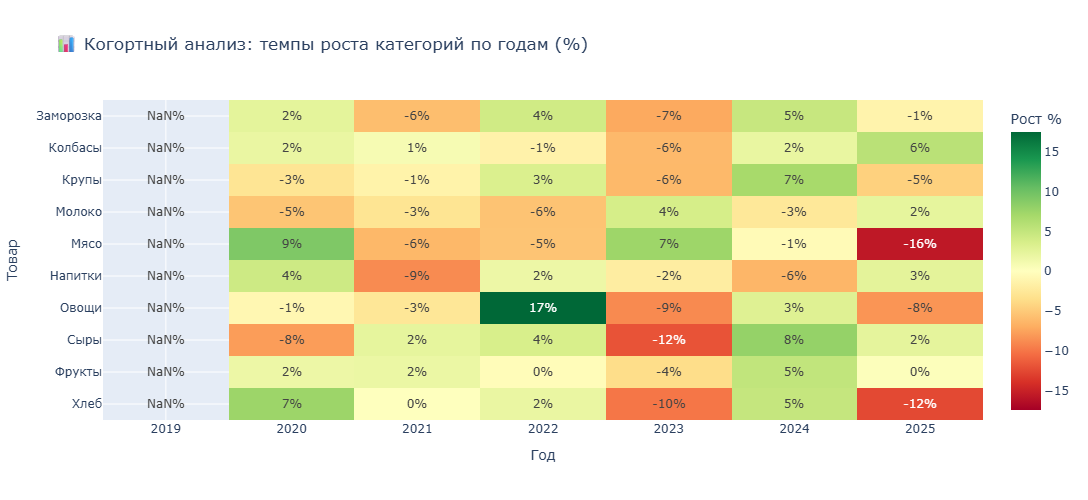


📊 Выручка по категориям и годам (млн руб):


Товар,Заморозка,Колбасы,Крупы,Молоко,Мясо,Напитки,Овощи,Сыры,Фрукты,Хлеб
Год,,,,,,,,,,
2019,172.90,174.50,170.70,177.10,167.00,172.60,156.30,182.60,165.20,160.60
2020,177.10,177.90,165.70,167.50,182.20,180.00,154.90,168.20,167.90,172.60
2021,166.70,179.30,163.40,162.50,170.80,164.10,150.80,172.00,171.00,172.70
2022,173.50,176.70,168.80,153.60,161.50,166.80,177.10,178.10,170.30,176.10
2023,161.00,165.80,158.30,159.20,173.40,163.40,161.30,156.80,164.10,158.60
2024,168.70,169.20,169.20,155.10,172.50,152.90,166.10,169.20,172.50,166.20
2025,166.50,178.70,161.50,158.70,145.40,156.80,152.30,173.20,173.00,145.50


In [32]:
# ============================================================
# 3.9 КОГОРТНЫЙ АНАЛИЗ КАТЕГОРИЙ ПО ГОДАМ
# ============================================================

# Pivot: год × товар → выручка
cohort_data = df.groupby(['Год', 'Товар'])['Выручка'].sum().unstack()

# Темпы роста по годам
cohort_growth = cohort_data.pct_change() * 100

# Heatmap роста
fig = px.imshow(
    cohort_growth.T,
    labels=dict(x="Год", y="Товар", color="Рост %"),
    aspect="auto",
    color_continuous_scale="RdYlGn",
    color_continuous_midpoint=0,
    title="📊 Когортный анализ: темпы роста категорий по годам (%)"
)

fig.update_layout(height=500)
fig.update_traces(
    text=cohort_growth.T.round(0).values,
    texttemplate="%{text}%",
    hovertemplate="<b>%{y}</b><br>Год: %{x}<br>Рост: %{z:.1f}%<extra></extra>"
)

fig.show()

# Сводка по годам
print("\n📊 Выручка по категориям и годам (млн руб):")
display((cohort_data / 1e6).round(1))

---
# 📐 БЛОК 4: АНАЛИЗ ОПТИМАЛЬНОЙ ПЛОЩАДИ МАГАЗИНА

**4 метода определения оптимальной площади:**

1. **Производительность на м²** — максимизация выручки/м² и прибыли/м²
2. **Нелинейная регрессия** — поиск точки убывающей отдачи
3. **Предельная эффективность** — маржинальный анализ (∂Revenue/∂Area)
4. **Кластеризация + бенчмаркинг** — лидеры по размерным сегментам

---

In [33]:
# ============================================================
# 4.0 ЗАГРУЗКА ДАННЫХ О ПЛОЩАДИ
# ============================================================

print("="*80)
print("📐 БЛОК 4: АНАЛИЗ ОПТИМАЛЬНОЙ ПЛОЩАДИ МАГАЗИНА")
print("="*80)

STORE_AREA_FILE = "store.xlsx"

try:
    df_area = pd.read_excel(STORE_AREA_FILE)
    col_names = df_area.columns.tolist()
    print(f"✓ Загружен файл: {STORE_AREA_FILE}")
    print(f"  Колонки: {col_names}")

    df_area = df_area.rename(columns={
        "Магазин": "Магазин_адрес",
        "Торговая площадь магазина": "Площадь_м2"
    })

    print("Первые строки файла:")
    display(df_area.head())

except FileNotFoundError:
    print(f"❌ ОШИБКА: Файл {STORE_AREA_FILE} не найден!")
    raise

📐 БЛОК 4: АНАЛИЗ ОПТИМАЛЬНОЙ ПЛОЩАДИ МАГАЗИНА
✓ Загружен файл: store.xlsx
  Колонки: ['Магазин', 'Торговая площадь магазина']
Первые строки файла:


,Магазин_адрес,Площадь_м2
0,Магазин 1,500
1,Магазин 2,215
2,Магазин 3,589
3,Магазин 4,658
4,Магазин 5,412


In [34]:
# ============================================================
# 4.1 ОБЪЕДИНЕНИЕ ДАННЫХ
# ============================================================

# Загрузка основных данных продаж
df = pd.read_excel("final_flat_clean.xlsx")

# Рассчитываем метрики
df["Выручка"] = df["Сумма в чеке"]
df["Валовая_прибыль"] = df["Наценка продажи в чеке"]
df["Store_ID"] = df["Магазин"].str.extract(r"(\d+)").astype(float)

# Агрегируем продажи по магазинам (за весь период)
store_summary = df.groupby("Магазин").agg({
    "Выручка": "sum",
    "Валовая_прибыль": "sum",
    "Число чеков": "sum",
    "Store_ID": "first"
}).reset_index()

store_summary["Маржа_%"] = store_summary["Валовая_прибыль"] / store_summary["Выручка"] * 100

# Пытаемся смержить по названию магазина
df_area["Магазин"] = df_area["Магазин_адрес"]

# Мерж данных
store_with_area = store_summary.merge(
    df_area[["Магазин", "Площадь_м2"]],
    on="Магазин",
    how="left"
)

# Проверка успешности мержа
missing_area = store_with_area["Площадь_м2"].isna().sum()
if missing_area > 0:
    print(f"⚠️ ВНИМАНИЕ: Для {missing_area} магазинов не найдена площадь!")
    print("Магазины без площади:")
    print(store_with_area[store_with_area["Площадь_м2"].isna()]["Магазин"].tolist())
    print("Доступные адреса в файле площадей:")
    print(df_area["Магазин_адрес"].tolist())

    # Попытка автоматического сопоставления по номеру
    print("🔧 Попытка автоматического сопоставления...")
    store_with_area["temp_id"] = store_with_area["Магазин"].str.extract(r"(\d+)").astype(float)
    df_area["temp_id"] = df_area["Магазин_адрес"].str.extract(r"(\d+)").astype(float)

    store_with_area = store_with_area.drop(columns=["Площадь_м2"], errors="ignore")
    store_with_area = store_with_area.merge(
        df_area[["temp_id", "Площадь_м2"]],
        on="temp_id",
        how="left"
    )
    store_with_area = store_with_area.drop(columns=["temp_id"], errors="ignore")
    df_area = df_area.drop(columns=["temp_id"], errors="ignore")

    missing_after = store_with_area["Площадь_м2"].isna().sum()
    if missing_after == 0:
        print("✓ Автоматическое сопоставление успешно!")
    else:
        print(f"❌ Остались магазины без площади: {missing_after}")

# Удаляем магазины без площади
store_with_area = store_with_area.dropna(subset=["Площадь_м2"])

print(f"✓ Объединение завершено: {len(store_with_area)} магазинов с площадью")
print(f"  Средняя площадь: {store_with_area['Площадь_м2'].mean():.1f} м²")
print(f"  Диапазон: {store_with_area['Площадь_м2'].min():.1f} - {store_with_area['Площадь_м2'].max():.1f} м²")

# Расчёт базовых метрик
store_with_area["Выручка_на_м2"] = store_with_area["Выручка"] / store_with_area["Площадь_м2"]
store_with_area["Прибыль_на_м2"] = store_with_area["Валовая_прибыль"] / store_with_area["Площадь_м2"]
store_with_area["Трафик_на_м2"] = store_with_area["Число чеков"] / store_with_area["Площадь_м2"]

display(store_with_area.sort_values("Store_ID").round(0))

✓ Объединение завершено: 20 магазинов с площадью
  Средняя площадь: 523.9 м²
  Диапазон: 214.0 - 988.0 м²


,Магазин,Выручка,Валовая_прибыль,Число чеков,Store_ID,Маржа_%,Площадь_м2,Выручка_на_м2,Прибыль_на_м2,Трафик_на_м2
0,Магазин 1,"1,376,988.00","476,611.00",354146,1.00,35.00,500,"2,754.00",953.00,708.00
11,Магазин 2,"1,369,856.00","475,023.00",355168,2.00,35.00,215,"6,371.00","2,209.00","1,652.00"
13,Магазин 3,"1,394,917.00","479,845.00",361043,3.00,34.00,589,"2,368.00",815.00,613.00
14,Магазин 4,"1,376,982.00","481,805.00",355721,4.00,35.00,658,"2,093.00",732.00,541.00
15,Магазин 5,"1,394,441.00","486,572.00",361282,5.00,35.00,412,"3,385.00","1,181.00",877.00
16,Магазин 6,"1,373,027.00","475,595.00",366060,6.00,35.00,325,"4,225.00","1,463.00","1,126.00"
17,Магазин 7,"1,376,092.00","478,190.00",356914,7.00,35.00,658,"2,091.00",727.00,542.00
18,Магазин 8,"1,359,675.00","479,266.00",358140,8.00,35.00,954,"1,425.00",502.00,375.00
19,Магазин 9,"1,381,854.00","482,358.00",352664,9.00,35.00,554,"2,494.00",871.00,637.00
1,Магазин 10,"1,342,667.00","474,626.00",355818,10.00,35.00,854,"1,572.00",556.00,417.00



📊 МЕТОД 1: АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ НА М²
Цель: Найти площадь с максимальной выручкой/м² и прибылью/м²

🏆 ТОП-5 по выручке на м²:


,Магазин,Площадь_м2,Выручка_на_м2,Прибыль_на_м2
11,Магазин 2,215,"6,371.00","2,209.00"
12,Магазин 20,214,"6,359.00","2,225.00"
7,Магазин 16,222,"6,159.00","2,129.00"
16,Магазин 6,325,"4,225.00","1,463.00"
3,Магазин 12,355,"3,808.00","1,334.00"



🏆 ТОП-5 по прибыли на м²:


,Магазин,Площадь_м2,Прибыль_на_м2,Выручка_на_м2
12,Магазин 20,214,"2,225.00","6,359.00"
11,Магазин 2,215,"2,209.00","6,371.00"
7,Магазин 16,222,"2,129.00","6,159.00"
16,Магазин 6,325,"1,463.00","4,225.00"
3,Магазин 12,355,"1,334.00","3,808.00"



💡 ВЫВОД МЕТОДА 1:
  • Оптимальная площадь (по выручке/м²): 266 м²
  • Оптимальная площадь (по прибыли/м²): 266 м²
  • Рекомендуемый диапазон: 214-355 м²


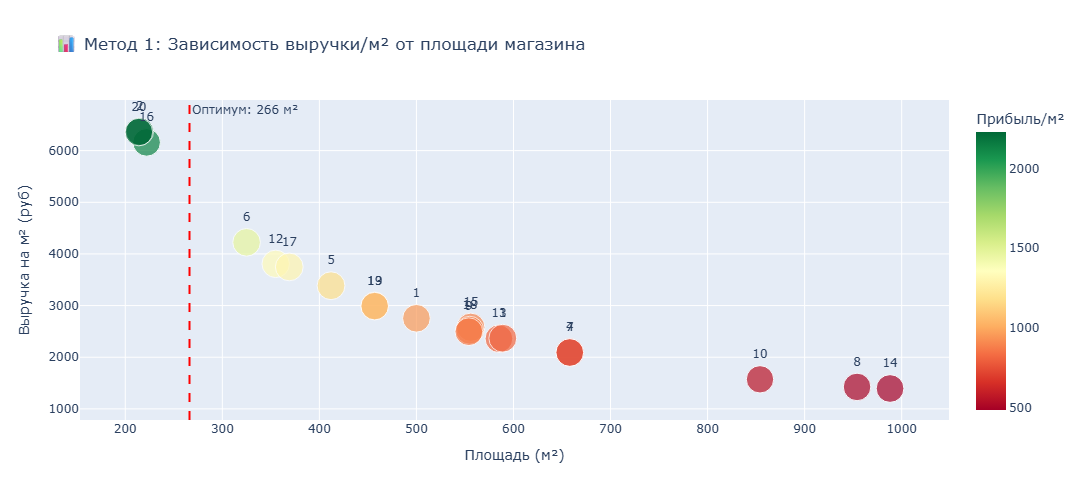

In [35]:
# ============================================================
# МЕТОД 1: АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ НА М²
# ============================================================

print("\n" + "="*80)
print("📊 МЕТОД 1: АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ НА М²")
print("="*80)
print("Цель: Найти площадь с максимальной выручкой/м² и прибылью/м²\n")

# Сортировка по эффективности
top_by_revenue_m2 = store_with_area.nlargest(5, 'Выручка_на_м2')[['Магазин', 'Площадь_м2', 'Выручка_на_м2', 'Прибыль_на_м2']]
top_by_profit_m2 = store_with_area.nlargest(5, 'Прибыль_на_м2')[['Магазин', 'Площадь_м2', 'Прибыль_на_м2', 'Выручка_на_м2']]

print("🏆 ТОП-5 по выручке на м²:")
display(top_by_revenue_m2.round(0))

print("\n🏆 ТОП-5 по прибыли на м²:")
display(top_by_profit_m2.round(0))

# Оптимальная площадь = средняя площадь лидеров
optimal_area_method1_revenue = top_by_revenue_m2['Площадь_м2'].mean()
optimal_area_method1_profit = top_by_profit_m2['Площадь_м2'].mean()

print(f"\n💡 ВЫВОД МЕТОДА 1:")
print(f"  • Оптимальная площадь (по выручке/м²): {optimal_area_method1_revenue:.0f} м²")
print(f"  • Оптимальная площадь (по прибыли/м²): {optimal_area_method1_profit:.0f} м²")
print(f"  • Рекомендуемый диапазон: {top_by_revenue_m2['Площадь_м2'].min():.0f}-{top_by_revenue_m2['Площадь_м2'].max():.0f} м²")

# Визуализация
fig = px.scatter(
    store_with_area,
    x='Площадь_м2',
    y='Выручка_на_м2',
    size='Выручка',
    color='Прибыль_на_м2',
    text='Store_ID',
    title='📊 Метод 1: Зависимость выручки/м² от площади магазина',
    labels={'Площадь_м2': 'Площадь (м²)', 'Выручка_на_м2': 'Выручка на м² (руб)', 'Прибыль_на_м2': 'Прибыль/м²'},
    color_continuous_scale='RdYlGn'
)

fig.add_vline(x=optimal_area_method1_revenue, line_dash="dash", line_color="red",
              annotation_text=f"Оптимум: {optimal_area_method1_revenue:.0f} м²")

fig.update_traces(textposition='top center')
fig.update_layout(height=500)
fig.show()


📈 МЕТОД 2: НЕЛИНЕЙНАЯ РЕГРЕССИЯ
Цель: Найти точку убывающей отдачи (где дополнительная площадь даёт <10% прироста)

R² моделей:
  • Линейная: 0.000
  • Квадратичная: 0.218
  • Кубическая: 0.233

💡 ВЫВОД МЕТОДА 2:
  • Модель: Квадратичная (y = 0 + 184*x + -0.16*x²)
  • Оптимальная площадь (точка максимума): 582 м²
  • Точка убывающей отдачи (50% от макс): 404 м²


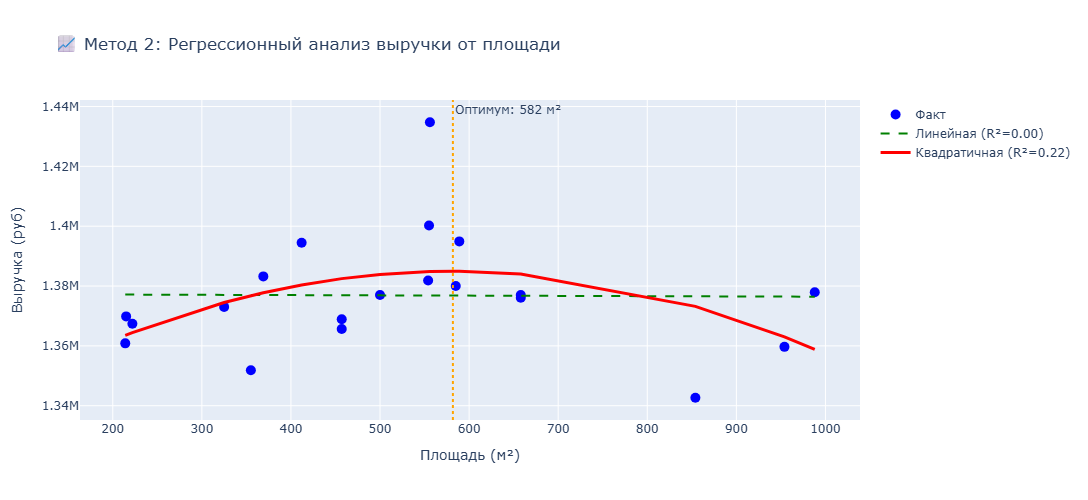

In [36]:
# ============================================================
# МЕТОД 2: НЕЛИНЕЙНАЯ РЕГРЕССИЯ (ПОИСК ТОЧКИ ПЕРЕГИБА)
# ============================================================

print("\n" + "="*80)
print("📈 МЕТОД 2: НЕЛИНЕЙНАЯ РЕГРЕССИЯ")
print("="*80)
print("Цель: Найти точку убывающей отдачи (где дополнительная площадь даёт <10% прироста)\n")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# Подготовка данных
X = store_with_area['Площадь_м2'].values.reshape(-1, 1)
y_revenue = store_with_area['Выручка'].values

# 1. Линейная модель
lr = LinearRegression()
lr.fit(X, y_revenue)
y_pred_linear = lr.predict(X)
r2_linear = r2_score(y_revenue, y_pred_linear)

# 2. Полиномиальная модель (2-й степени)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y_revenue)
y_pred_poly = lr_poly.predict(X_poly)
r2_poly = r2_score(y_revenue, y_pred_poly)

# 3. Кубическая модель
poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(X)
lr_poly3 = LinearRegression()
lr_poly3.fit(X_poly3, y_revenue)
y_pred_poly3 = lr_poly3.predict(X_poly3)
r2_poly3 = r2_score(y_revenue, y_pred_poly3)

print(f"R² моделей:")
print(f"  • Линейная: {r2_linear:.3f}")
print(f"  • Квадратичная: {r2_poly:.3f}")
print(f"  • Кубическая: {r2_poly3:.3f}")

# Поиск оптимума для квадратичной модели
if r2_poly > r2_linear and len(lr_poly.coef_) >= 3:
    a, b, c = lr_poly.coef_[0], lr_poly.coef_[1], lr_poly.coef_[2]
    if c < 0:
        optimal_area_method2 = -b / (2 * c)
        print(f"\n💡 ВЫВОД МЕТОДА 2:")
        print(f"  • Модель: Квадратичная (y = {a:.0f} + {b:.0f}*x + {c:.2f}*x²)")
        print(f"  • Оптимальная площадь (точка максимума): {optimal_area_method2:.0f} м²")

        areas = np.arange(X.min(), X.max(), 10)
        revenues = lr_poly.predict(poly.transform(areas.reshape(-1, 1)))
        marginal_revenue = np.gradient(revenues, areas)

        threshold_idx = np.where(marginal_revenue < marginal_revenue.max() * 0.5)[0]
        if len(threshold_idx) > 0:
            diminishing_point = areas[threshold_idx[0]]
            print(f"  • Точка убывающей отдачи (50% от макс): {diminishing_point:.0f} м²")
    else:
        optimal_area_method2 = X.mean()
        print(f"\n💡 ВЫВОД МЕТОДА 2:")
        print(f"  • Зависимость линейная, максимум не обнаружен")
        print(f"  • Рекомендуемая площадь (среднее): {optimal_area_method2:.0f} м²")
else:
    optimal_area_method2 = X.mean()
    print(f"\n💡 ВЫВОД МЕТОДА 2:")
    print(f"  • Лучшая модель: Линейная (постоянная отдача от площади)")
    print(f"  • Рекомендуемая площадь (среднее): {optimal_area_method2:.0f} м²")

# Визуализация
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=store_with_area['Площадь_м2'],
    y=store_with_area['Выручка'],
    mode='markers',
    name='Факт',
    marker=dict(size=10, color='blue')
))

X_sorted = np.sort(X.flatten())
fig.add_trace(go.Scatter(
    x=X_sorted,
    y=lr.predict(X_sorted.reshape(-1, 1)),
    mode='lines',
    name=f'Линейная (R²={r2_linear:.2f})',
    line=dict(dash='dash', color='green')
))

fig.add_trace(go.Scatter(
    x=X_sorted,
    y=lr_poly.predict(poly.transform(X_sorted.reshape(-1, 1))),
    mode='lines',
    name=f'Квадратичная (R²={r2_poly:.2f})',
    line=dict(color='red', width=3)
))

if 'optimal_area_method2' in locals():
    fig.add_vline(x=optimal_area_method2, line_dash="dot", line_color="orange",
                  annotation_text=f"Оптимум: {optimal_area_method2:.0f} м²")

fig.update_layout(
    title='📈 Метод 2: Регрессионный анализ выручки от площади',
    xaxis_title='Площадь (м²)',
    yaxis_title='Выручка (руб)',
    height=500
)
fig.show()


💹 МЕТОД 3: ПРЕДЕЛЬНАЯ ЭФФЕКТИВНОСТЬ
Цель: Найти площадь, где предельная выручка начинает падать

📊 Предельная выручка по площади:
       Магазин  Площадь_м2      Выручка  Marginal_Revenue  Marginal_Revenue_MA
12  Магазин 20         214 1,360,840.00               NaN                  NaN
11   Магазин 2         215 1,369,856.00          9,015.00             9,015.00
7   Магазин 16         222 1,367,382.00           -353.00             4,331.00
16   Магазин 6         325 1,373,027.00             55.00             2,906.00
3   Магазин 12         355 1,351,830.00           -707.00              -335.00
8   Магазин 17         369 1,383,228.00          2,243.00               530.00
15   Магазин 5         412 1,394,441.00            261.00               599.00
4   Магазин 13         457 1,368,922.00           -567.00               645.00
10  Магазин 19         457 1,365,660.00              -inf              -153.00
0    Магазин 1         500 1,376,988.00            263.00              -152.00


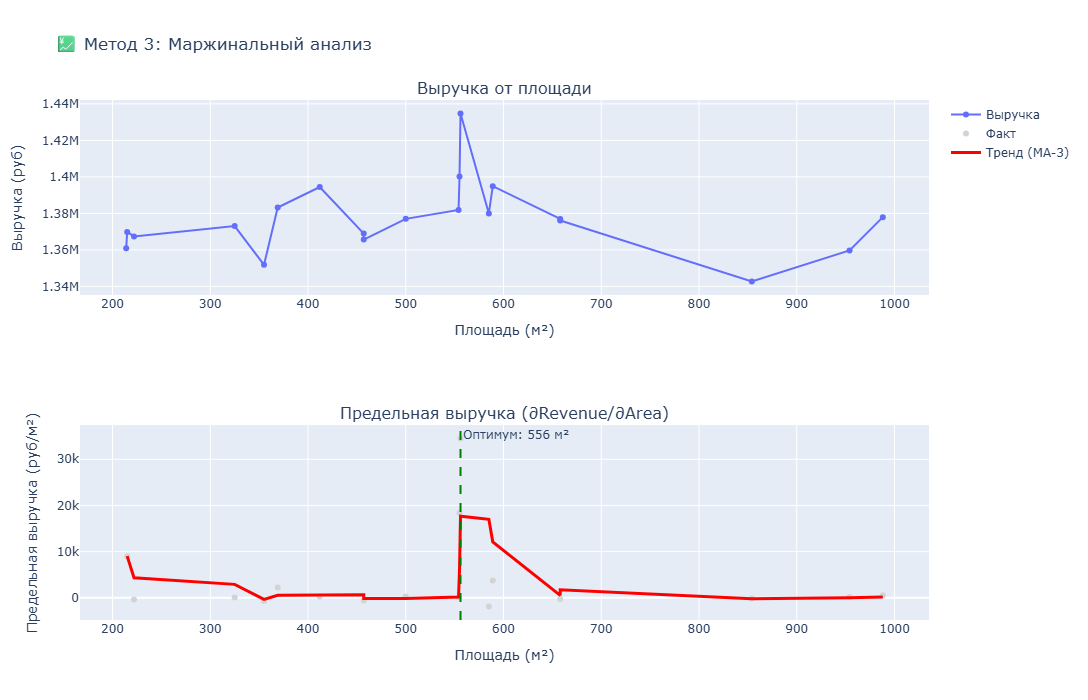

In [37]:
# ============================================================
# МЕТОД 3: ПРЕДЕЛЬНАЯ ЭФФЕКТИВНОСТЬ (МАРЖИНАЛЬНЫЙ АНАЛИЗ)
# ============================================================

print("\n" + "="*80)
print("💹 МЕТОД 3: ПРЕДЕЛЬНАЯ ЭФФЕКТИВНОСТЬ")
print("="*80)
print("Цель: Найти площадь, где предельная выручка начинает падать\n")

# Сортируем магазины по площади
marginal_df = store_with_area.sort_values('Площадь_м2').copy()

# Расчёт предельной выручки
marginal_df['Delta_Area'] = marginal_df['Площадь_м2'].diff()
marginal_df['Delta_Revenue'] = marginal_df['Выручка'].diff()
marginal_df['Marginal_Revenue'] = marginal_df['Delta_Revenue'] / marginal_df['Delta_Area']

# Скользящее среднее для сглаживания
marginal_df['Marginal_Revenue_MA'] = marginal_df['Marginal_Revenue'].rolling(3, min_periods=1).mean()

# Находим точку пика
peak_idx = marginal_df['Marginal_Revenue_MA'].idxmax()
optimal_area_method3 = marginal_df.loc[peak_idx, 'Площадь_м2'] if not pd.isna(peak_idx) else marginal_df['Площадь_м2'].median()

print("📊 Предельная выручка по площади:")
print(marginal_df[['Магазин', 'Площадь_м2', 'Выручка', 'Marginal_Revenue', 'Marginal_Revenue_MA']].round(0))

print(f"\n💡 ВЫВОД МЕТОДА 3:")
print(f"  • Оптимальная площадь (пик предельной выручки): {optimal_area_method3:.0f} м²")
print(f"  • Макс. предельная выручка: {marginal_df['Marginal_Revenue_MA'].max():.0f} руб/м²")

# Визуализация
fig = make_subplots(rows=2, cols=1, subplot_titles=['Выручка от площади', 'Предельная выручка (∂Revenue/∂Area)'])

fig.add_trace(
    go.Scatter(x=marginal_df['Площадь_м2'], y=marginal_df['Выручка'],
               mode='lines+markers', name='Выручка'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=marginal_df['Площадь_м2'], y=marginal_df['Marginal_Revenue'],
               mode='markers', name='Факт', marker=dict(color='lightgray')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=marginal_df['Площадь_м2'], y=marginal_df['Marginal_Revenue_MA'],
               mode='lines', name='Тренд (MA-3)', line=dict(color='red', width=3)),
    row=2, col=1
)

fig.add_vline(x=optimal_area_method3, line_dash="dash", line_color="green", row=2, col=1,
              annotation_text=f"Оптимум: {optimal_area_method3:.0f} м²")

fig.update_layout(height=700, title_text='💹 Метод 3: Маржинальный анализ')
fig.update_xaxes(title_text="Площадь (м²)")
fig.update_yaxes(title_text="Выручка (руб)", row=1, col=1)
fig.update_yaxes(title_text="Предельная выручка (руб/м²)", row=2, col=1)
fig.show()


🎯 МЕТОД 4: КЛАСТЕРИЗАЦИЯ ПО РАЗМЕРУ + БЕНЧМАРКИНГ
Цель: Разделить магазины на размерные кластеры и найти лидеров в каждом

📊 Характеристики кластеров:


,Площадь_м2_min,Площадь_м2_max,Площадь_м2_mean,Выручка_на_м2_mean,Прибыль_на_м2_mean,Магазин_count
Размер_кластер,,,,,,
Малые,214,412,302.00,"4,865.00","1,692.00",7
Средние,457,556,513.00,"2,723.00",951.00,6
Крупные,585,988,755.00,"1,900.00",662.00,7



🏆 Лидеры по кластерам (максимальная прибыль/м²):

Средние:
  Магазин: Магазин 19
  Площадь: 457 м²
  Выручка/м²: 2988 руб
  Прибыль/м²: 1051 руб

Крупные:
  Магазин: Магазин 11
  Площадь: 585 м²
  Выручка/м²: 2359 руб
  Прибыль/м²: 815 руб

Малые:
  Магазин: Магазин 20
  Площадь: 214 м²
  Выручка/м²: 6359 руб
  Прибыль/м²: 2225 руб

💡 ВЫВОД МЕТОДА 4:
  • Оптимальная площадь (среднее лидеров): 419 м²
  • Рекомендации по кластерам:
    - Средние: ориентир 457 м² (эталон: Магазин 19)
    - Крупные: ориентир 585 м² (эталон: Магазин 11)
    - Малые: ориентир 214 м² (эталон: Магазин 20)


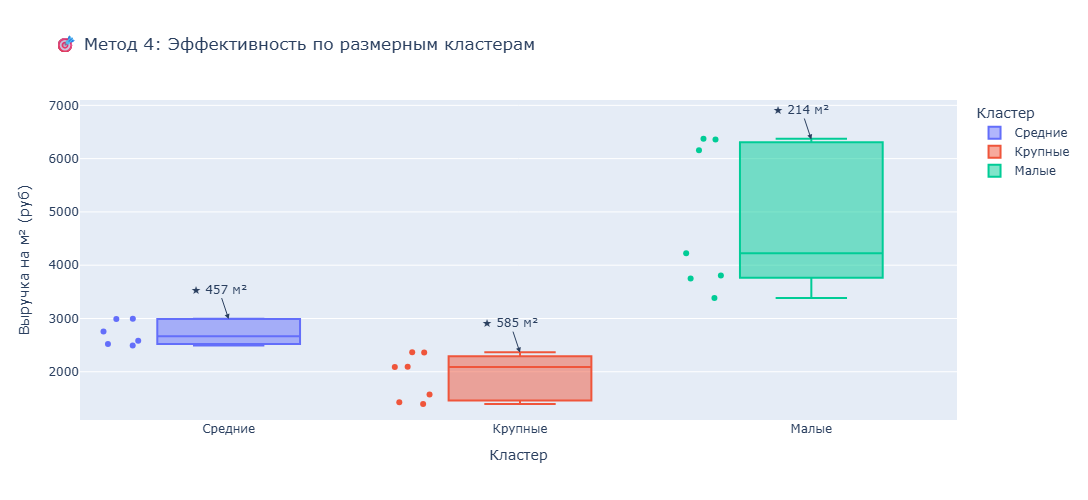

In [38]:
# ============================================================
# МЕТОД 4: КЛАСТЕРИЗАЦИЯ + БЕНЧМАРКИНГ
# ============================================================

print("\n" + "="*80)
print("🎯 МЕТОД 4: КЛАСТЕРИЗАЦИЯ ПО РАЗМЕРУ + БЕНЧМАРКИНГ")
print("="*80)
print("Цель: Разделить магазины на размерные кластеры и найти лидеров в каждом\n")

# Определяем кластеры по площади (квантили)
store_with_area['Размер_кластер'] = pd.qcut(
    store_with_area['Площадь_м2'],
    q=3,
    labels=['Малые', 'Средние', 'Крупные'],
    duplicates='drop'
)

# Анализ по кластерам
cluster_analysis = store_with_area.groupby('Размер_кластер').agg({
    'Площадь_м2': ['min', 'max', 'mean'],
    'Выручка_на_м2': 'mean',
    'Прибыль_на_м2': 'mean',
    'Магазин': 'count'
}).round(0)

cluster_analysis.columns = ['_'.join(col).strip() for col in cluster_analysis.columns]
print("📊 Характеристики кластеров:")
display(cluster_analysis)

# Находим лидеров в каждом кластере
print("\n🏆 Лидеры по кластерам (максимальная прибыль/м²):")
leaders = []
for cluster in store_with_area['Размер_кластер'].unique():
    cluster_data = store_with_area[store_with_area['Размер_кластер'] == cluster]
    leader = cluster_data.nlargest(1, 'Прибыль_на_м2').iloc[0]
    leaders.append(leader)
    print(f"\n{cluster}:")
    print(f"  Магазин: {leader['Магазин']}")
    print(f"  Площадь: {leader['Площадь_м2']:.0f} м²")
    print(f"  Выручка/м²: {leader['Выручка_на_м2']:.0f} руб")
    print(f"  Прибыль/м²: {leader['Прибыль_на_м2']:.0f} руб")

# Оптимальная площадь = средняя площадь лидеров
optimal_area_method4 = np.mean([l['Площадь_м2'] for l in leaders])

print(f"\n💡 ВЫВОД МЕТОДА 4:")
print(f"  • Оптимальная площадь (среднее лидеров): {optimal_area_method4:.0f} м²")
print(f"  • Рекомендации по кластерам:")
for cluster in store_with_area['Размер_кластер'].unique():
    cluster_data = store_with_area[store_with_area['Размер_кластер'] == cluster]
    leader = cluster_data.nlargest(1, 'Прибыль_на_м2').iloc[0]
    print(f"    - {cluster}: ориентир {leader['Площадь_м2']:.0f} м² (эталон: {leader['Магазин']})")

# Визуализация
fig = px.box(
    store_with_area,
    x='Размер_кластер',
    y='Выручка_на_м2',
    points='all',
    title='🎯 Метод 4: Эффективность по размерным кластерам',
    labels={'Размер_кластер': 'Кластер', 'Выручка_на_м2': 'Выручка на м² (руб)'},
    color='Размер_кластер'
)

for leader in leaders:
    fig.add_annotation(
        x=leader['Размер_кластер'],
        y=leader['Выручка_на_м2'],
        text=f"★ {leader['Площадь_м2']:.0f} м²",
        showarrow=True,
        arrowhead=2
    )

fig.update_layout(height=500)
fig.show()


📋 ИТОГОВАЯ СВОДКА: ОПТИМАЛЬНАЯ ПЛОЩАДЬ МАГАЗИНА


,Метод,Оптимальная площадь (м²),Обоснование
0,1. Производительность на м²,266.20,Средняя площадь топ-5 по прибыли/м²
1,2. Нелинейная регрессия,581.80,Точка максимума квадратичной функции
2,3. Предельная эффективность,556.00,Пик предельной выручки
3,4. Кластеризация + бенчмаркинг,418.67,Средняя площадь лидеров по кластерам



🎯 ФИНАЛЬНАЯ РЕКОМЕНДАЦИЯ:
  • Оптимальная площадь: 487 м² (медиана всех методов)
  • Рекомендуемый диапазон: 381 - 562 м² (25-75 перцентиль)

📊 Статистика текущих магазинов:
  • Средняя площадь: 524 м²
  • Медианная площадь: 527 м²
  • Диапазон: 214 - 988 м²

🏪 Распределение магазинов по статусу:
Статус_площади
🟢 Оптимальная        7
🟠 Слишком большая    7
🔴 Слишком малая      6
Name: count, dtype: int64

💡 РЕКОМЕНДАЦИИ ПО МАГАЗИНАМ:

🔴 Слишком малая:
  • Магазин 12: 355 м² → расширить на 132 м²
  • Магазин 16: 222 м² → расширить на 265 м²
  • Магазин 17: 369 м² → расширить на 118 м²
  • Магазин 2: 215 м² → расширить на 272 м²
  • Магазин 20: 214 м² → расширить на 273 м²
  • Магазин 6: 325 м² → расширить на 162 м²

🟠 Слишком большая:
  • Магазин 10: 854 м² → сократить на 367 м²
  • Магазин 11: 585 м² → сократить на 98 м²
  • Магазин 14: 988 м² → сократить на 501 м²
  • Магазин 3: 589 м² → сократить на 102 м²
  • Магазин 4: 658 м² → сократить на 171 м²
  • Магазин 7: 658 м² → сократить

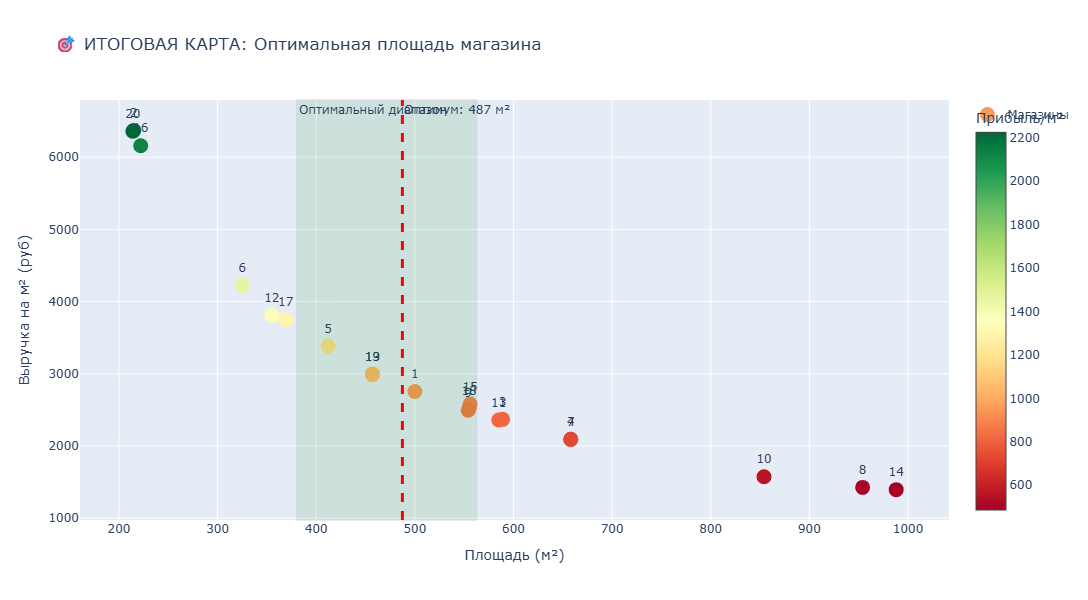


✓ АНАЛИЗ ЗАВЕРШЁН


In [39]:
# ============================================================
# ИТОГОВАЯ СВОДКА ВСЕХ МЕТОДОВ
# ============================================================

print("\n" + "="*80)
print("📋 ИТОГОВАЯ СВОДКА: ОПТИМАЛЬНАЯ ПЛОЩАДЬ МАГАЗИНА")
print("="*80)

results = {
    'Метод': [
        '1. Производительность на м²',
        '2. Нелинейная регрессия',
        '3. Предельная эффективность',
        '4. Кластеризация + бенчмаркинг'
    ],
    'Оптимальная площадь (м²)': [
        optimal_area_method1_profit,
        optimal_area_method2,
        optimal_area_method3,
        optimal_area_method4
    ],
    'Обоснование': [
        'Средняя площадь топ-5 по прибыли/м²',
        'Точка максимума квадратичной функции',
        'Пик предельной выручки',
        'Средняя площадь лидеров по кластерам'
    ]
}

summary_df = pd.DataFrame(results)
display(summary_df)

# Итоговая рекомендация (медиана всех методов)
valid_areas = [a for a in results['Оптимальная площадь (м²)'] if a is not None]
final_optimal_area = np.median(valid_areas)
final_optimal_range = (np.percentile(valid_areas, 25), np.percentile(valid_areas, 75))

print(f"\n🎯 ФИНАЛЬНАЯ РЕКОМЕНДАЦИЯ:")
print(f"  • Оптимальная площадь: {final_optimal_area:.0f} м² (медиана всех методов)")
print(f"  • Рекомендуемый диапазон: {final_optimal_range[0]:.0f} - {final_optimal_range[1]:.0f} м² (25-75 перцентиль)")
print(f"\n📊 Статистика текущих магазинов:")
print(f"  • Средняя площадь: {store_with_area['Площадь_м2'].mean():.0f} м²")
print(f"  • Медианная площадь: {store_with_area['Площадь_м2'].median():.0f} м²")
print(f"  • Диапазон: {store_with_area['Площадь_м2'].min():.0f} - {store_with_area['Площадь_м2'].max():.0f} м²")

# Классификация магазинов
store_with_area['Статус_площади'] = store_with_area['Площадь_м2'].apply(
    lambda x: '🟢 Оптимальная' if final_optimal_range[0] <= x <= final_optimal_range[1]
              else ('🔴 Слишком малая' if x < final_optimal_range[0] else '🟠 Слишком большая')
)

print(f"\n🏪 Распределение магазинов по статусу:")
print(store_with_area['Статус_площади'].value_counts())

print(f"\n💡 РЕКОМЕНДАЦИИ ПО МАГАЗИНАМ:")
for status in ['🔴 Слишком малая', '🟠 Слишком большая']:
    stores = store_with_area[store_with_area['Статус_площади'] == status]
    if len(stores) > 0:
        print(f"\n{status}:")
        for _, store in stores.iterrows():
            delta = final_optimal_area - store['Площадь_м2']
            action = 'расширить' if delta > 0 else 'сократить'
            print(f"  • {store['Магазин']}: {store['Площадь_м2']:.0f} м² → {action} на {abs(delta):.0f} м²")

# Финальная визуализация
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=store_with_area['Площадь_м2'],
    y=store_with_area['Выручка_на_м2'],
    mode='markers+text',
    marker=dict(
        size=15,
        color=store_with_area['Прибыль_на_м2'],
        colorscale='RdYlGn',
        showscale=True,
        colorbar=dict(title="Прибыль/м²")
    ),
    text=store_with_area['Store_ID'],
    textposition='top center',
    name='Магазины',
    hovertemplate='<b>%{text}</b><br>Площадь: %{x:.0f} м²<br>Выручка/м²: %{y:,.0f} руб<extra></extra>'
))

fig.add_vrect(
    x0=final_optimal_range[0], x1=final_optimal_range[1],
    fillcolor="green", opacity=0.1,
    annotation_text="Оптимальный диапазон", annotation_position="top left"
)

fig.add_vline(x=final_optimal_area, line_dash="dash", line_color="red", line_width=3,
              annotation_text=f"Оптимум: {final_optimal_area:.0f} м²")

fig.update_layout(
    title='🎯 ИТОГОВАЯ КАРТА: Оптимальная площадь магазина',
    xaxis_title='Площадь (м²)',
    yaxis_title='Выручка на м² (руб)',
    height=600,
    showlegend=True
)

fig.show()

print("\n" + "="*80)
print("✓ АНАЛИЗ ЗАВЕРШЁН")
print("="*80)